# Hands-On NLP
## Class 4

<span style="color:magenta">Group Names:</span>

* Carlos Cuevas Villarmín
* Javier Alejandro Lopetegui González
* José Felipe Espinosa Orjuela

### Outline:

- Simple tokenization

- Words and indices

- Initialization

- Visualization

- Forward, cost, backward, training

- First on a sentence, then on a larger text

Main goal: understand the transformations needed to obtain vector representations

In [2]:
import doctest
import re
from collections import Counter
from datetime import datetime
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

In [3]:
tqdm.pandas()

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 4)

print("sklearn's version:", sklearn.__version__)    # 1.4.0
print("pandas's version:", pd.__version__)          # 2.2.0

sklearn's version: 1.3.0
pandas's version: 1.5.3


In [4]:
%config InlineBackend.figure_format="retina"  # For high DPI display

In [5]:
doctest.testmod(optionflags=doctest.ELLIPSIS)

TestResults(failed=0, attempted=0)

In [6]:
DATA = Path("./data/enwiki")

# ENWIKI_FP = DATA / "enwiki_20180420_100d.txt"
ENWIKI_FP = DATA / "enwiki-50k_100d-clean.txt"

EPS = np.finfo(float).eps

TOY_CORPUS = """What is a word embedding?
A word vector (or embeddings) is a dense representation,
which captures semantic relationships between words."""

In [7]:
def tokenize(text, pattern=r"\w+"):
    """Tokenize a text into a list of tokens.
    >>> tokenize("Let's do hands-on Natural Language Processing!")
    ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing']
    """
    return re.findall(pattern, text.lower())

In [8]:
pprint(tokenize(TOY_CORPUS), compact=True)

['what', 'is', 'a', 'word', 'embedding', 'a', 'word', 'vector', 'or',
 'embeddings', 'is', 'a', 'dense', 'representation', 'which', 'captures',
 'semantic', 'relationships', 'between', 'words']


In [9]:
def build_vocab(tokens, show_df=False):
    """
    Builds a vocabulary and a mapping from tokens to indices from a given list of tokens.

    Parameters:
    - tokens (List[str] or Iterable[str]): A sequence of tokens from which the vocabulary will be built.
    - show_df (bool, optional): A flag to determine whether to display a DataFrame containing the tokens and their counts. Defaults to False.

    Returns:
    - vocab (List[str]): A list of unique tokens (vocabulary) ordered by frequency in descending order.
    - voc2idx (Dict[str, int]): A dictionary mapping each token to its index in the vocabulary.
    """
    df = pd.DataFrame(Counter(tokens).most_common(), columns=["token", "count"])
    if show_df:
        display(df)

    vocab = df.token.to_list()
    voc2idx = {word: idx for idx, word in enumerate(vocab)}

    return vocab, voc2idx

### CBOW

For the calculation of the word2vec we also have the CBOW (continuous bag of words) method as an alternative to Skipgram.
In CBOW, we try to predict the central word from the whole context of the central word.
Our xs, ys training data have fewer inputs, only as many as the text has words, but are richer.
For prediction, we sum the context vectors to predict the center.

In [10]:
def generate_cbow_data(tokens, window_size):
    """
    Create the pairs xs, ys for the training:
    xs and ys have the same length (index of the central word,
    index of an observed word of the context of the central word)

    generate_cbow_data(
       ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing'],
       window_size=2,
    )
    ([[1, 2],
      [0, 2, 3],
      [0, 1, 3, 4],
      [1, 2, 4, 5],
      [2, 3, 5, 6],
      [3, 4, 6, 7],
      [4, 5, 7],
      [5, 6]],
     [0, 1, 2, 3, 4, 5, 6, 7])
    """
    tokens_n = len(tokens)
    _, voc2idx = build_vocab(tokens)
    xs, ys = [], []

    for i in range(tokens_n):
        if i < window_size:
            context = tokens[:i] + tokens[i+1: i+1+window_size]
        elif i > tokens_n - window_size:
            context = tokens[i-window_size:i] + tokens[i+1:]
        else:
            context = tokens[i-window_size:i] + tokens[i+1:i+1+window_size]

        xs.append([voc2idx[word] for word in context])
        ys.append(voc2idx[tokens[i]])
        

    return xs, ys

In [11]:
#Proof that it is correct
generate_cbow_data(
       ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing'],
       window_size=2,
    )

([[1, 2],
  [0, 2, 3],
  [0, 1, 3, 4],
  [1, 2, 4, 5],
  [2, 3, 5, 6],
  [3, 4, 6, 7],
  [4, 5, 7],
  [5, 6]],
 [0, 1, 2, 3, 4, 5, 6, 7])

### Skipgram

In [12]:
def generate_skip_data(tokens, window_size):
    """
    create the pairs xs, ys for the training:
    xs and ys have the same length (index of the central word,
    index of an observed word of the context of the central word)

    >>> tokens = ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing']
    >>> xs, ys = generate_skip_data(tokens, window_size=2)
    >>> print(len(xs[0]), len(ys[0]))
    26 26
    >>> print(xs)
    [[0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7]]
    >>> print(ys)
    [[1, 2, 0, 2, 3, 0, 1, 3, 4, 1, 2, 4, 5, 2, 3, 5, 6, 3, 4, 6, 7, 4, 5, 7, 5, 6]]
    """
    tokens_n = len(tokens)
    _, voc2idx = build_vocab(tokens)
    xs, ys = [], []

    for i in range(tokens_n):
        if i < window_size:
            context = tokens[:i] + tokens[i+1: i+1+window_size]
        elif i > tokens_n - window_size:
            context = tokens[i-window_size:i] + tokens[i+1:]
        else:
            context = tokens[i-window_size:i] + tokens[i+1:i+1+window_size]

        for word in context:
            xs.append(voc2idx[tokens[i]])
            ys.append(voc2idx[word])
    return [xs], [ys]

In [13]:
#Proof that the implementation is correct
tokens = ['let', 's', 'do', 'hands', 'on', 'natural', 'language', 'processing']
xs, ys = generate_skip_data(tokens, window_size=2)
print(len(xs[0]), len(ys[0]))
print(xs)
print(ys)

26 26
[[0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7]]
[[1, 2, 0, 2, 3, 0, 1, 3, 4, 1, 2, 4, 5, 2, 3, 5, 6, 3, 4, 6, 7, 4, 5, 7, 5, 6]]


In [14]:
# let's test these functions:
tokens = tokenize(TOY_CORPUS)
pprint(tokens, compact=True)

vocab, voc2idx = build_vocab(tokens, show_df=True)

xs, ys = generate_cbow_data(tokens, 3)
print(len(xs), len(ys))
xs

['what', 'is', 'a', 'word', 'embedding', 'a', 'word', 'vector', 'or',
 'embeddings', 'is', 'a', 'dense', 'representation', 'which', 'captures',
 'semantic', 'relationships', 'between', 'words']


,token,count
0,a,3
1,is,2
2,word,2
3,what,1
4,embedding,1
5,vector,1
6,or,1
7,embeddings,1
8,dense,1
9,representation,1


20 20


[[1, 0, 2],
 [3, 0, 2, 4],
 [3, 1, 2, 4, 0],
 [3, 1, 0, 4, 0, 2],
 [1, 0, 2, 0, 2, 5],
 [0, 2, 4, 2, 5, 6],
 [2, 4, 0, 5, 6, 7],
 [4, 0, 2, 6, 7, 1],
 [0, 2, 5, 7, 1, 0],
 [2, 5, 6, 1, 0, 8],
 [5, 6, 7, 0, 8, 9],
 [6, 7, 1, 8, 9, 10],
 [7, 1, 0, 9, 10, 11],
 [1, 0, 8, 10, 11, 12],
 [0, 8, 9, 11, 12, 13],
 [8, 9, 10, 12, 13, 14],
 [9, 10, 11, 13, 14, 15],
 [10, 11, 12, 14, 15],
 [11, 12, 13, 15],
 [12, 13, 14]]

In [15]:
ys

[3, 1, 0, 2, 4, 0, 2, 5, 6, 7, 1, 0, 8, 9, 10, 11, 12, 13, 14, 15]

In [16]:
xs, ys = generate_skip_data(tokens, 3)
xs, ys = np.array(xs), np.array(ys)
print(xs.shape, ys.shape)
print(xs)

(1, 108) (1, 108)
[[ 3  3  3  1  1  1  1  0  0  0  0  0  2  2  2  2  2  2  4  4  4  4  4  4
   0  0  0  0  0  0  2  2  2  2  2  2  5  5  5  5  5  5  6  6  6  6  6  6
   7  7  7  7  7  7  1  1  1  1  1  1  0  0  0  0  0  0  8  8  8  8  8  8
   9  9  9  9  9  9 10 10 10 10 10 10 11 11 11 11 11 11 12 12 12 12 12 12
  13 13 13 13 13 14 14 14 14 15 15 15]]


In [17]:
print(ys)

[[ 1  0  2  3  0  2  4  3  1  2  4  0  3  1  0  4  0  2  1  0  2  0  2  5
   0  2  4  2  5  6  2  4  0  5  6  7  4  0  2  6  7  1  0  2  5  7  1  0
   2  5  6  1  0  8  5  6  7  0  8  9  6  7  1  8  9 10  7  1  0  9 10 11
   1  0  8 10 11 12  0  8  9 11 12 13  8  9 10 12 13 14  9 10 11 13 14 15
  10 11 12 14 15 11 12 13 15 12 13 14]]


In [18]:
vocab, voc2idx = build_vocab(tokens)
vocab_size = len(vocab)
ys = np.array(ys)
m = np.array(ys).shape[1]

# ys in one-hot encoding:
one_hot_ys = np.zeros((vocab_size, m))
one_hot_ys[ys.flatten(), np.arange(m)] = 1  # important to understand for later!
one_hot_ys.shape  # can you explain the shape?

(16, 108)

The shape is $16 \times 108$ because for each word in the vocabulary we will have a one in every position corresponding to a context where it was as a non central word. 108 in this case is the sum of the size of every context in the data.

### 🚧 TODO:

*   Explain why there are three 3's, four 1's... in `xs`

These three 3's correspond to the first context with the word *what*, with index 3 in the vocabulary, as the central word. This is the first token of the text, that is why it just have the right window of context. Same for the four ones, corresponding to the word *is* with index 1 in the corpus. In this case the left context  windows has size 1 and the right one has size 3, 4 in total. In general you will have the same index repeated as many times as the size of the context considering left and right windows (maximum 6 for this case as the window size is 3).

*   Explain why there are more 0's than, e.g., 3's in `ys`

Index = 0 represent the word 'a' that appears 3 times in the text so it will appear in more context than for example index 3 ('what') which just appears once so the amount of context (depending on the window_size value) will be lower. So, the more occurrence of a word in a text, the more its index appears in ys.

In [19]:
def initialize_embeddings(vocab_size, emb_size, seed=None):
    """
    vocab_size (int): vocabulary size of your corpus or training data
    emb_size (int): word embedding size (dimensions to represent each word)
    🚧 TODO: complete the "_____"
    returns a matrix of shape: (vocab_size, emb_size)
    each row corresponds to the initial embedding of a word in the vocabulary that will be randomly initialized
    with a normal distribution (mean=0, std=0.01)
    end TODO
    """
    rng = np.random.default_rng(seed)
    return rng.normal(loc=0, scale=0.01, size=(vocab_size, emb_size))

Check out the parameters in the doc: [np.random.Generator.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html#numpy.random.Generator.normal).

In [20]:
def initialize_dense(input_size, output_size, seed=None):
    """
    input_size (int): size of the input to the dense layer
    output_size (int): size of the output of the dense layer
    🚧 TODO: complete the "______"
    returns a matrix of shape : (output_size, input_size)
    each row corresponds to the weights of the dense layer initialized with a normal distribution (mean=0, std=0.01)
    end TODO
    """
    rng = np.random.default_rng(seed)
    return rng.normal(loc=0, scale=0.01, size=(output_size, input_size))

In [21]:
def initialize_parameters(vocab_size, emb_size, seed=None):
    """
    Initialize all the training parameters
    """
    embs = initialize_embeddings(vocab_size, emb_size, seed)
    ws = initialize_dense(emb_size, vocab_size, seed)

    parameters = {}
    parameters["EMBS"] = embs
    parameters["W"] = ws

    return parameters

In [22]:
# for example an embedding of dimension 5
parameters = initialize_parameters(len(vocab), emb_size=5, seed=42)

In [23]:
print(parameters["EMBS"].shape, parameters["W"].shape)

(16, 5) (16, 5)


In [24]:
# We can multiply them:
(parameters["EMBS"].T @ parameters["W"]).shape

(5, 5)

In [25]:
def plot_embedding(vs, indices, vocab):
    pca = PCA(n_components=2)
    data = pca.fit_transform(vs).transpose()
    xs, ys = data[0], data[1]
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.scatter(xs, ys, c="green")
    for i, idx in enumerate(indices):
        ax.annotate(
            vocab[idx], (xs[i], ys[i]), xytext=(5, 5), textcoords="offset points"
        )
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("2 dimensions of the word embeddings")
    plt.show()

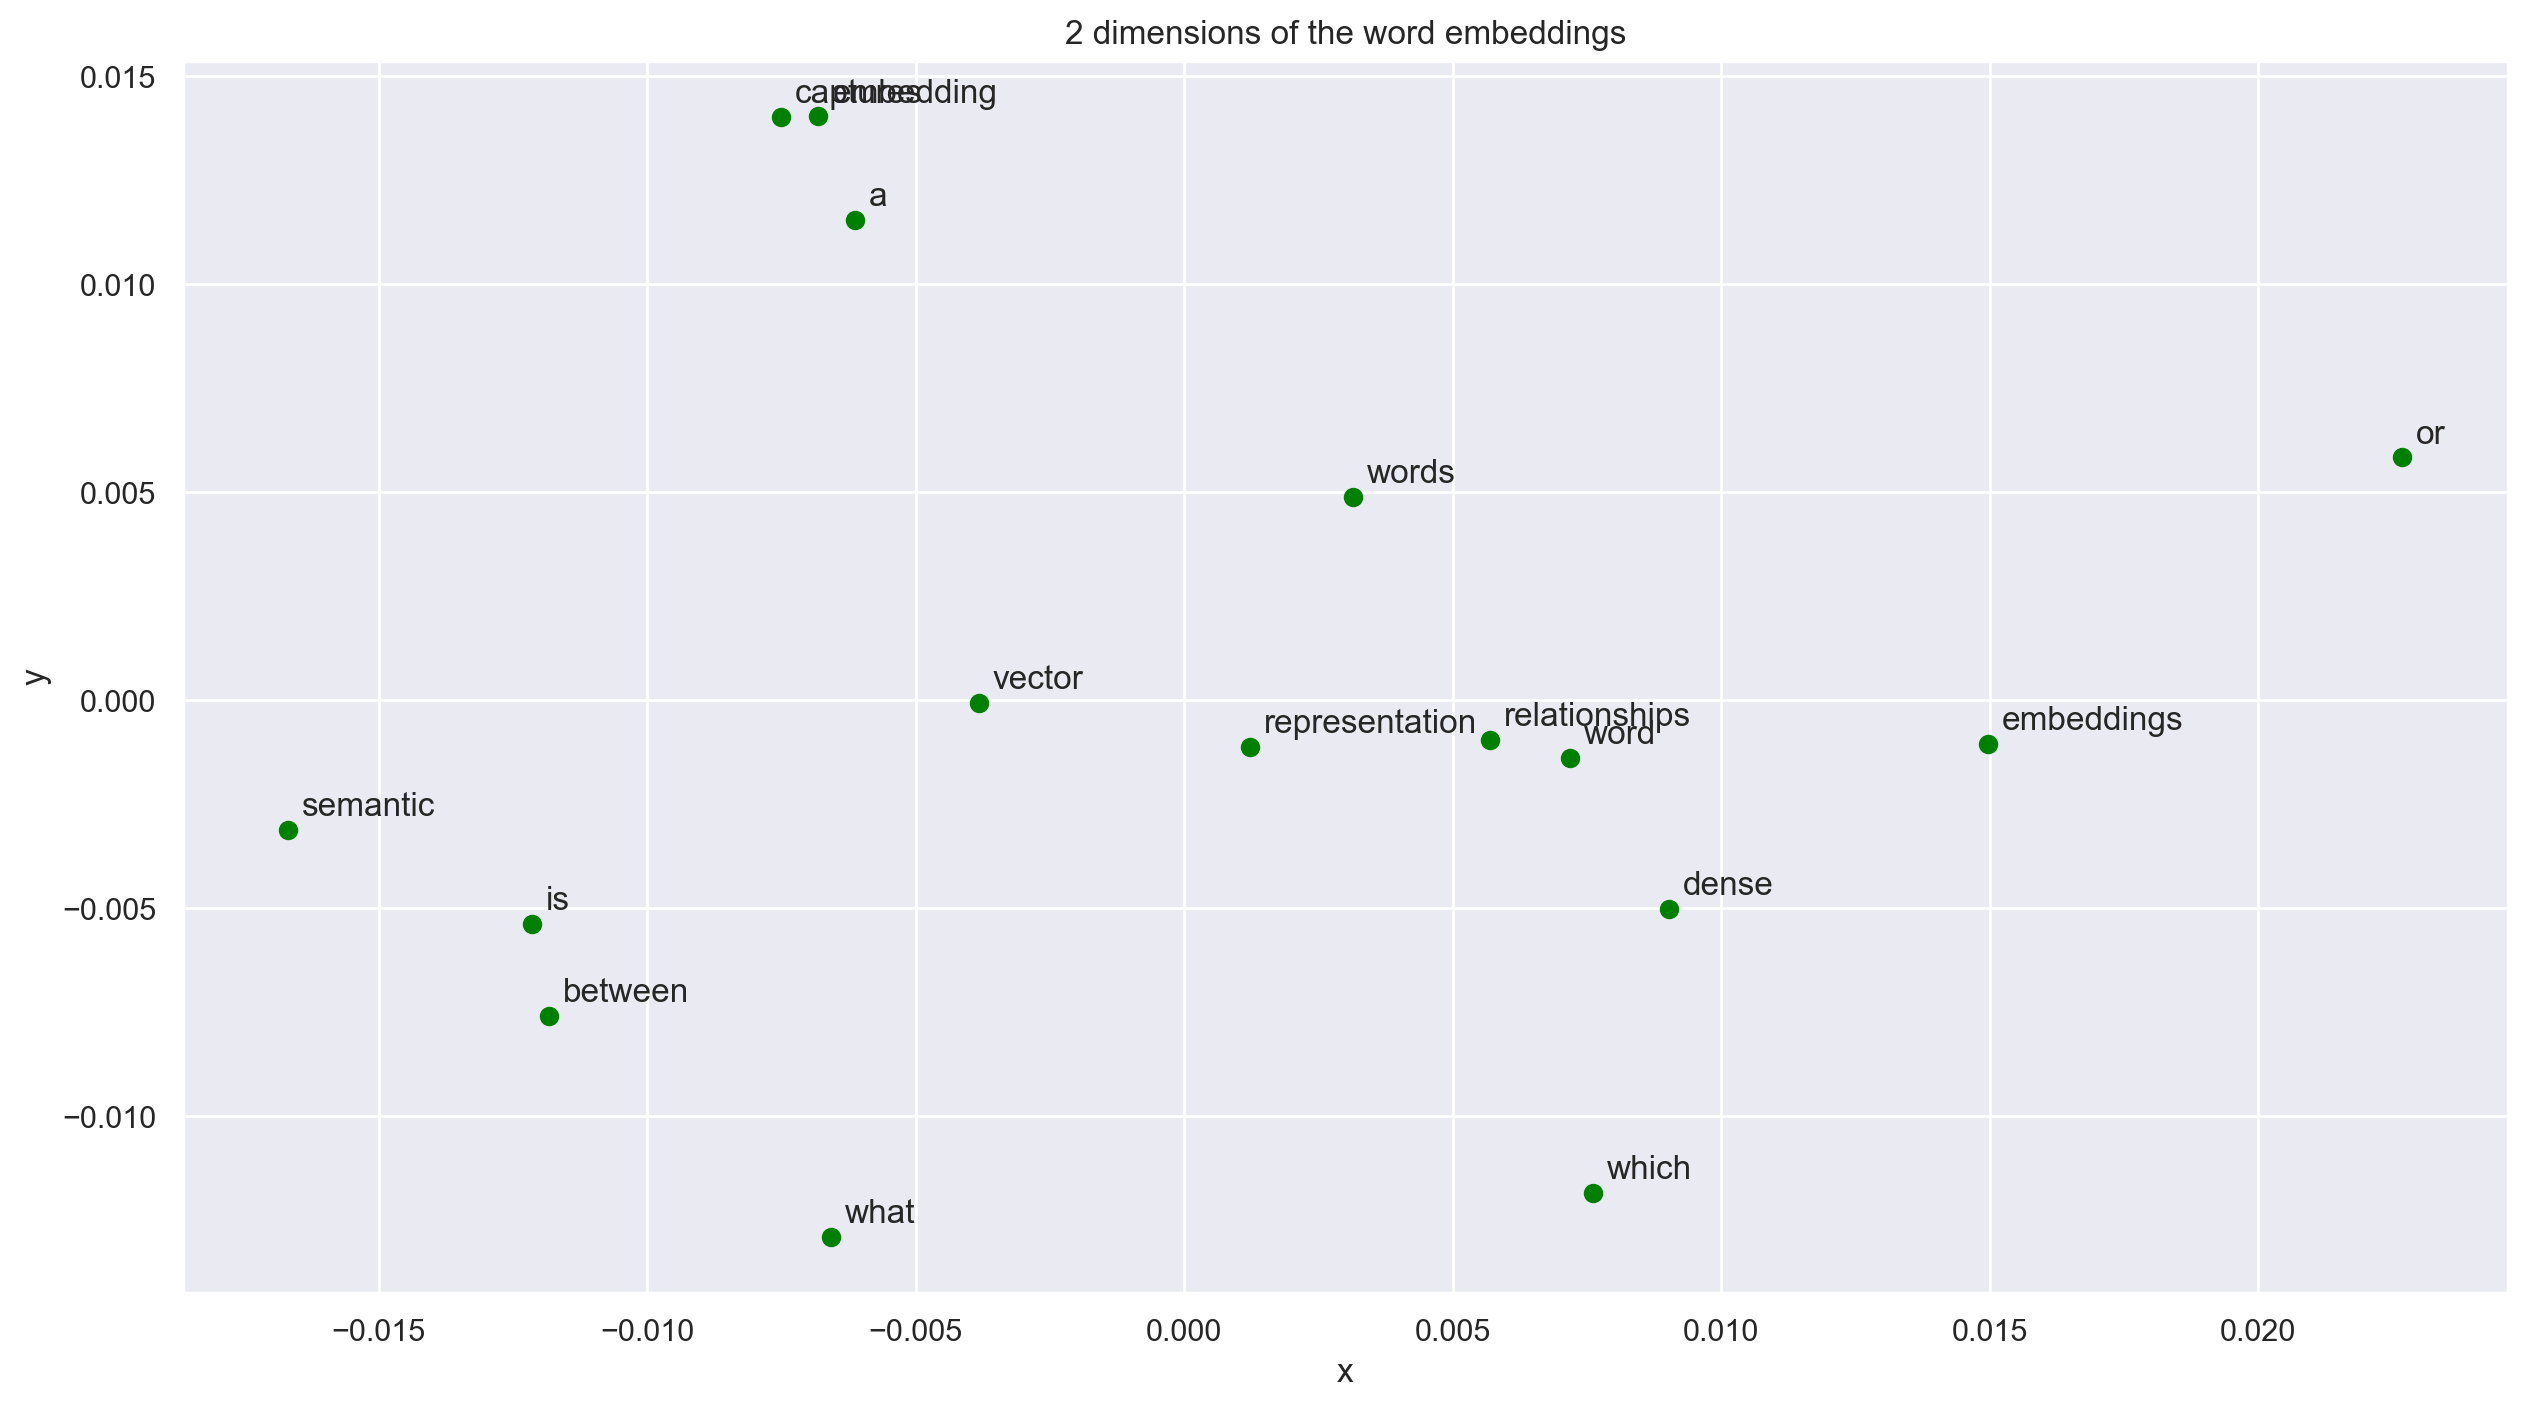

In [26]:
# plotting all the words that have just been initialized:
# print(parameters["emb"].shape)
plot_embedding(parameters["EMBS"], voc2idx.values(), vocab)

In [27]:
def ind_to_word_embs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained
    returns a matrix of word vectors as columns with shape (emb_size, m)   
    """
    m = inds.shape[1]
    embs = parameters["EMBS"]

    # Select the rows of the embedding matrix corresponding to the indices
    #     flatten() -> 1D array (as many elements as indices)
    w_embs = embs[inds.flatten(), :].T

    assert w_embs.shape == (embs.shape[1], m)

    return w_embs

In [28]:
def linear_dense(w_embs, parameters):
    """
    w_embs: numpy array. shape: (emb_size, m)
    parameters: dict. weights to be trained
    returns: ws et zs
    ws: matrix of weights of the dense layer
    zs: output matrix of the dense layer
    zs is of shape: (ws.shape[0], m)
    """
    m = w_embs.shape[1]
    ws = parameters["W"]
    zs = np.dot(ws, w_embs)

    assert zs.shape == (ws.shape[0], m)

    return ws, zs

In [29]:
def softmax(zs):
    """
    zs: output out of the dense layer.
    shape: (vocab_size, m = number of input vectors (tokens to update))
    """
    softmax_out = np.divide(
        np.exp(zs), np.sum(np.exp(zs), axis=0, keepdims=True) + EPS
    )
    assert softmax_out.shape == zs.shape

    return softmax_out

In [30]:
def forward_propagation(inds, parameters):
    w_embs = ind_to_word_embs(inds, parameters)
    ws, zs = linear_dense(w_embs, parameters)
    softmax_out = softmax(zs)

    caches = {}
    caches["inds"] = inds
    caches["w_embs"] = w_embs
    caches["W"] = ws
    caches["Z"] = zs
    return softmax_out, caches

In [31]:
def cross_entropy(softmax_out, ys):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m=batch_size)
    ys: ground truth: indices à prédire. shape: (1, m)
    """
    m = softmax_out.shape[1]

    cost = -(1 / m) * np.sum(
        np.log(softmax_out[ys.flatten(), np.arange(ys.shape[1])] + EPS)
    )
    return cost

🚧 TODO, read this carrefully:

* From the softmax out, I select the lines corresponding to the predicted tokens

* It gives me the probabilities, I take the log, and I average it

* If the prediction was perfect, the probability would be 1, the log is 0 --> zero cost

* If not, I have a proba smaller than 1, I take the average of these probas logs (which are all negative)

* With the "$-$" it becomes positive, so it is a measure of the error of the prediction

* Note that `ys` can contain several times the same index to predict. It is counted as many times as it should be predicted.

$$\frac{dL}{dZ} = softmax\_out - ys$$

$$\frac{dL}{dW} = \frac{dL}{dZ}\times\frac{dZ}{dW}= \frac{dL}{dZ}\times w\_embs.T$$

$$ 
\frac{dL}{d w\_embs} = \frac{dL}{dZ}\times\frac{dZ}{d w\_embs}
    = \frac{dL}{dZ} \times W.T
$$

In [32]:
def softmax_backward(ys, softmax_out):
    """
    ys: labels of training data. shape: (1, m=batch_size)
    softmax_out: output out of softmax. shape: (vocab_size, m=batch_size)
    """
    m = ys.shape[1]

    # we compute the difference between the prediction and the ground truth (ys)
    # if the prediction was perfect, the dl_dz becomes 0
    # we only touch the lines to predict
    # if the token is not to be predicted, we do not touch the line
    softmax_out[ys.flatten(), np.arange(m)] -= 1.0
    dl_dz = softmax_out

    assert dl_dz.shape == softmax_out.shape
    return dl_dz

In [33]:
def dense_backward(dl_dz, caches):
    """
    dl_dz: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    dl_dz has negative values where something needs to be changed.
    the more negative they are, the worse it is.
    """
    ws = caches["W"]
    w_embs = caches["w_embs"]
    m = w_embs.shape[1]

    # we multiply where we need to change something:
    # dl_dz.shape = (vocab_size, m)
    dl_dw = (1 / m) * np.dot(dl_dz, w_embs.T)
    dl_dw_embs = np.dot(ws.T, dl_dz)

    assert ws.shape == dl_dw.shape
    assert w_embs.shape == dl_dw_embs.shape

    return dl_dw, dl_dw_embs

In [34]:
def backward_propagation(ys, softmax_out, caches):
    dl_dz = softmax_backward(ys, softmax_out)
    dl_dw, dl_dw_embs = dense_backward(dl_dz, caches)

    gradients = dict()
    gradients["dL_dZ"] = dl_dz
    gradients["dL_dW"] = dl_dw
    gradients["dL_dw_embs"] = dl_dw_embs

    return gradients

In [35]:
def update_parameters(parameters, caches, gradients, learning_rate):
    """
    here we update the embedding
    """
    vocab_size, emb_size = parameters["EMBS"].shape
    inds = caches["inds"]
    embs = parameters["EMBS"]
    dl_dw_embs = gradients["dL_dw_embs"]
    m = inds.shape[-1]

    # note that only the lines corresponding to the central words are modified
    embs[inds.flatten(), :] -= dl_dw_embs.T * learning_rate

    parameters["W"] -= learning_rate * gradients["dL_dW"]

In [36]:
def skipgram_model_training(
    xs,
    ys,
    vocab_size,
    emb_size,
    learning_rate,
    epochs,
    batch_size=256,
    parameters=None,
    print_cost=False,
    plot_cost=True,
):
    costs = []
    m = xs.shape[1]

    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)

    best_epoch = 0
    min_epoch_cost = float("inf")
    parameters["best_embeddings"] = parameters["EMBS"]

    begin_time = datetime.now()
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            batch_xs = xs[:, i : i + batch_size]
            batch_ys = ys[:, i : i + batch_size]

            softmax_out, caches = forward_propagation(batch_xs, parameters)
            cost = cross_entropy(softmax_out, batch_ys)
            gradients = backward_propagation(batch_ys, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            epoch_cost += cost

        costs.append(epoch_cost)
        
        if epoch_cost < min_epoch_cost:
            min_epoch_cost = epoch_cost
            best_epoch = epoch
            parameters["best_embeddings"] = parameters["EMBS"]
        
        if print_cost and epoch % 200 == 0:
            print(f"Cost after epoch {epoch:4d}: {epoch_cost:.4f}")
        if epoch % (epochs // 100) == 0:
            learning_rate *= 0.98
    end_time = datetime.now()
    print(f"training time: {end_time - begin_time}")
    print(
        f"🚧 TODO I've kept the embedding of epoch {best_epoch} "
        f"with cost {min_epoch_cost:.4f}."
    )
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel("# of epochs")
        plt.ylabel("cost")
    return parameters, min_epoch_cost

In [37]:
print(ys.shape, xs.shape, one_hot_ys.shape)

(1, 108) (1, 108) (16, 108)


Cost after epoch    0: 2.7727
Cost after epoch  200: 2.7478
Cost after epoch  400: 2.5700
Cost after epoch  600: 2.4533
Cost after epoch  800: 2.3350
Cost after epoch 1000: 2.2702
Cost after epoch 1200: 2.2406
Cost after epoch 1400: 2.2257
Cost after epoch 1600: 2.2174
Cost after epoch 1800: 2.2120
Cost after epoch 2000: 2.2082
Cost after epoch 2200: 2.2056
Cost after epoch 2400: 2.2040
Cost after epoch 2600: 2.2032
Cost after epoch 2800: 2.2030
training time: 0:00:01.567011
🚧 TODO I've kept the embedding of epoch 2772 with cost 2.2030.


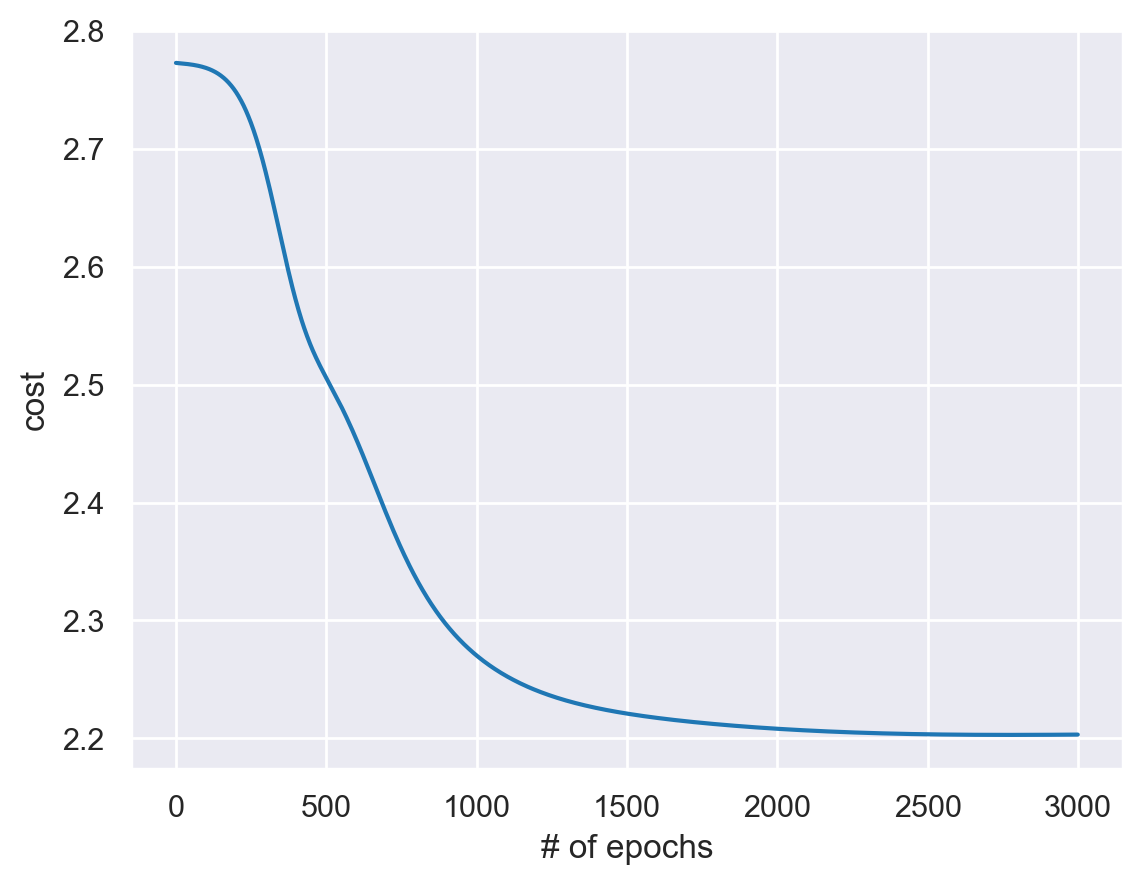

In [38]:
parameters, _ = skipgram_model_training(
    xs,
    ys,
    vocab_size,
    emb_size=50,
    learning_rate=0.05,
    epochs=3000,
    batch_size=128,
    parameters=None,
    print_cost=True,
)
# test with a small batch_size to see....


####  🚧 TODO:

- Keep the best model

- Visualize also the best model

In [39]:
#Compute for different batch sizes to see the impact on the cost
parameters = {}
for batch_size in range(5, 200, 10):
    print(f"Training with batch_size={batch_size}")
    parameters[batch_size], parameters[batch_size]['cost'] = skipgram_model_training(
        xs, ys, vocab_size, emb_size=50, learning_rate=0.05, epochs=3000, batch_size=batch_size, print_cost=False, plot_cost=False
    )

Training with batch_size=5
training time: 0:00:14.300150
🚧 TODO I've kept the embedding of epoch 213 with cost 45.8828.
Training with batch_size=15
training time: 0:00:03.821652
🚧 TODO I've kept the embedding of epoch 1153 with cost 16.4277.
Training with batch_size=25
training time: 0:00:01.648748
🚧 TODO I've kept the embedding of epoch 1730 with cost 10.2907.
Training with batch_size=35
training time: 0:00:01.741265
🚧 TODO I've kept the embedding of epoch 2855 with cost 8.0780.
Training with batch_size=45
training time: 0:00:01.522244
🚧 TODO I've kept the embedding of epoch 1061 with cost 6.4837.
Training with batch_size=55
training time: 0:00:01.230799
🚧 TODO I've kept the embedding of epoch 1655 with cost 4.3583.
Training with batch_size=65
training time: 0:00:00.963935
🚧 TODO I've kept the embedding of epoch 1152 with cost 4.4173.
Training with batch_size=75
training time: 0:00:00.850300
🚧 TODO I've kept the embedding of epoch 2999 with cost 4.3517.
Training with batch_size=85
tra

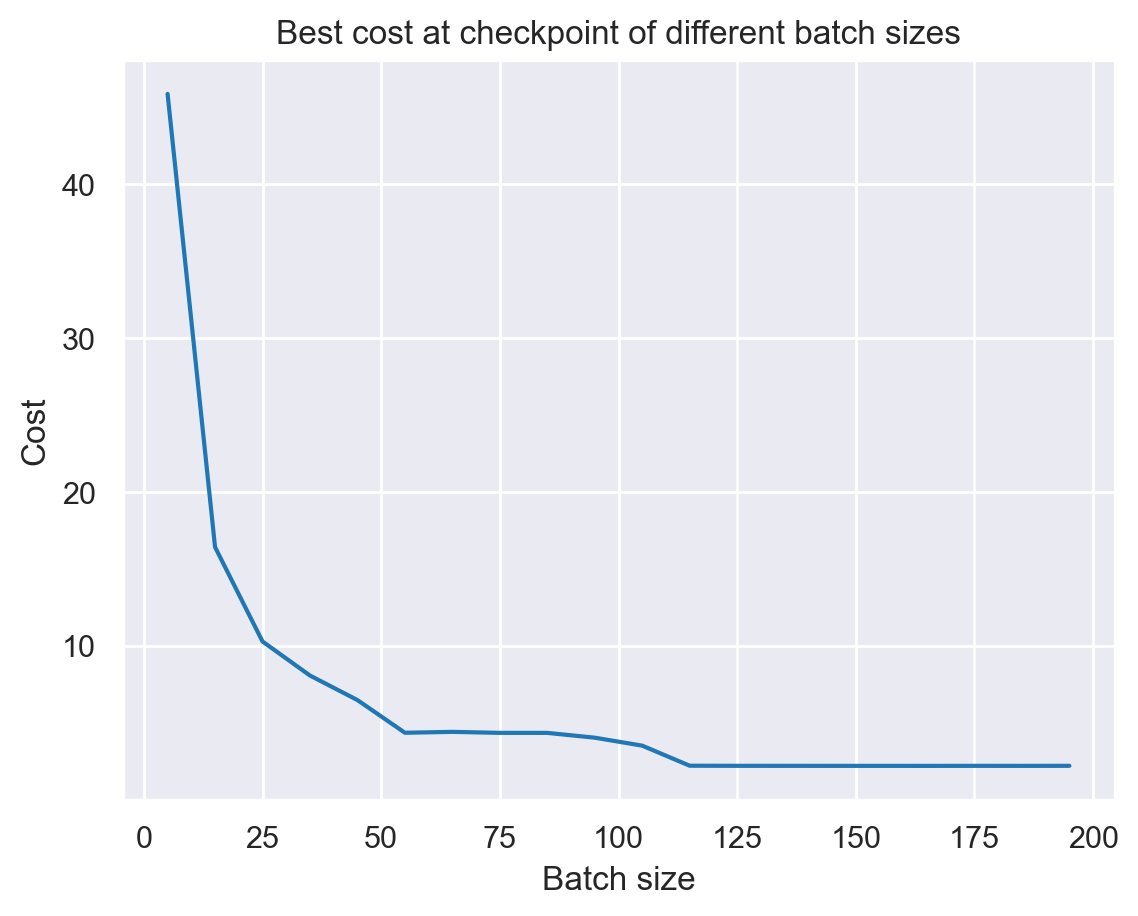

In [40]:
#plot the cost of each batch size
costs = [parameters[batch_size]['cost'] for batch_size in range(5, 200, 10)]
costs
plt.plot(range(5, 200, 10), costs)
plt.xlabel("Batch size")
plt.ylabel("Cost")
plt.title("Best cost at checkpoint of different batch sizes")
plt.show()

We can clearly see that with a very small batch size the cost is extremly high. We drop out the first two costs in order to analyse the evolution after that.

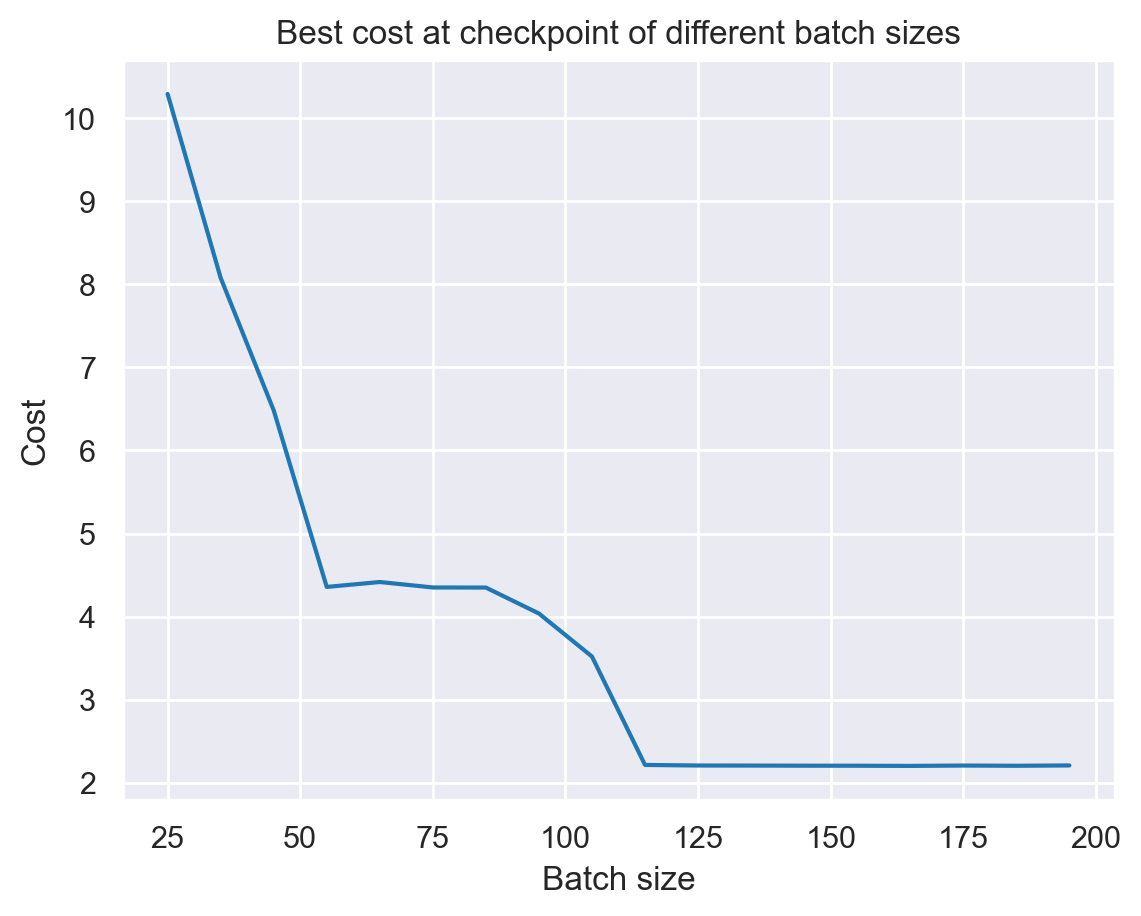

In [41]:
plt.plot(range(25, 200, 10), costs[2:])
plt.xlabel("Batch size")
plt.ylabel("Cost")
plt.title("Best cost at checkpoint of different batch sizes")
plt.show()

Finally, we can clearly see that after considering a batch_size greater than the length of x the cost function achieves similar values around 2. This is caused by passing through the model all the values at once per epoch. Additionally, the small variance between cost values reported for batch_size>108 are caused by the random initialization of the parameters of the model. Now we keep the parameters of the trained model where the cost function has achieved the minimum value.

In [42]:
# keep the best model
best_model_batch_size = min(parameters, key=lambda x: parameters[x]['cost'])
print(f"Best model batch size: {best_model_batch_size}")
#parameters = parameters[best_model_batch_size]

Best model batch size: 165


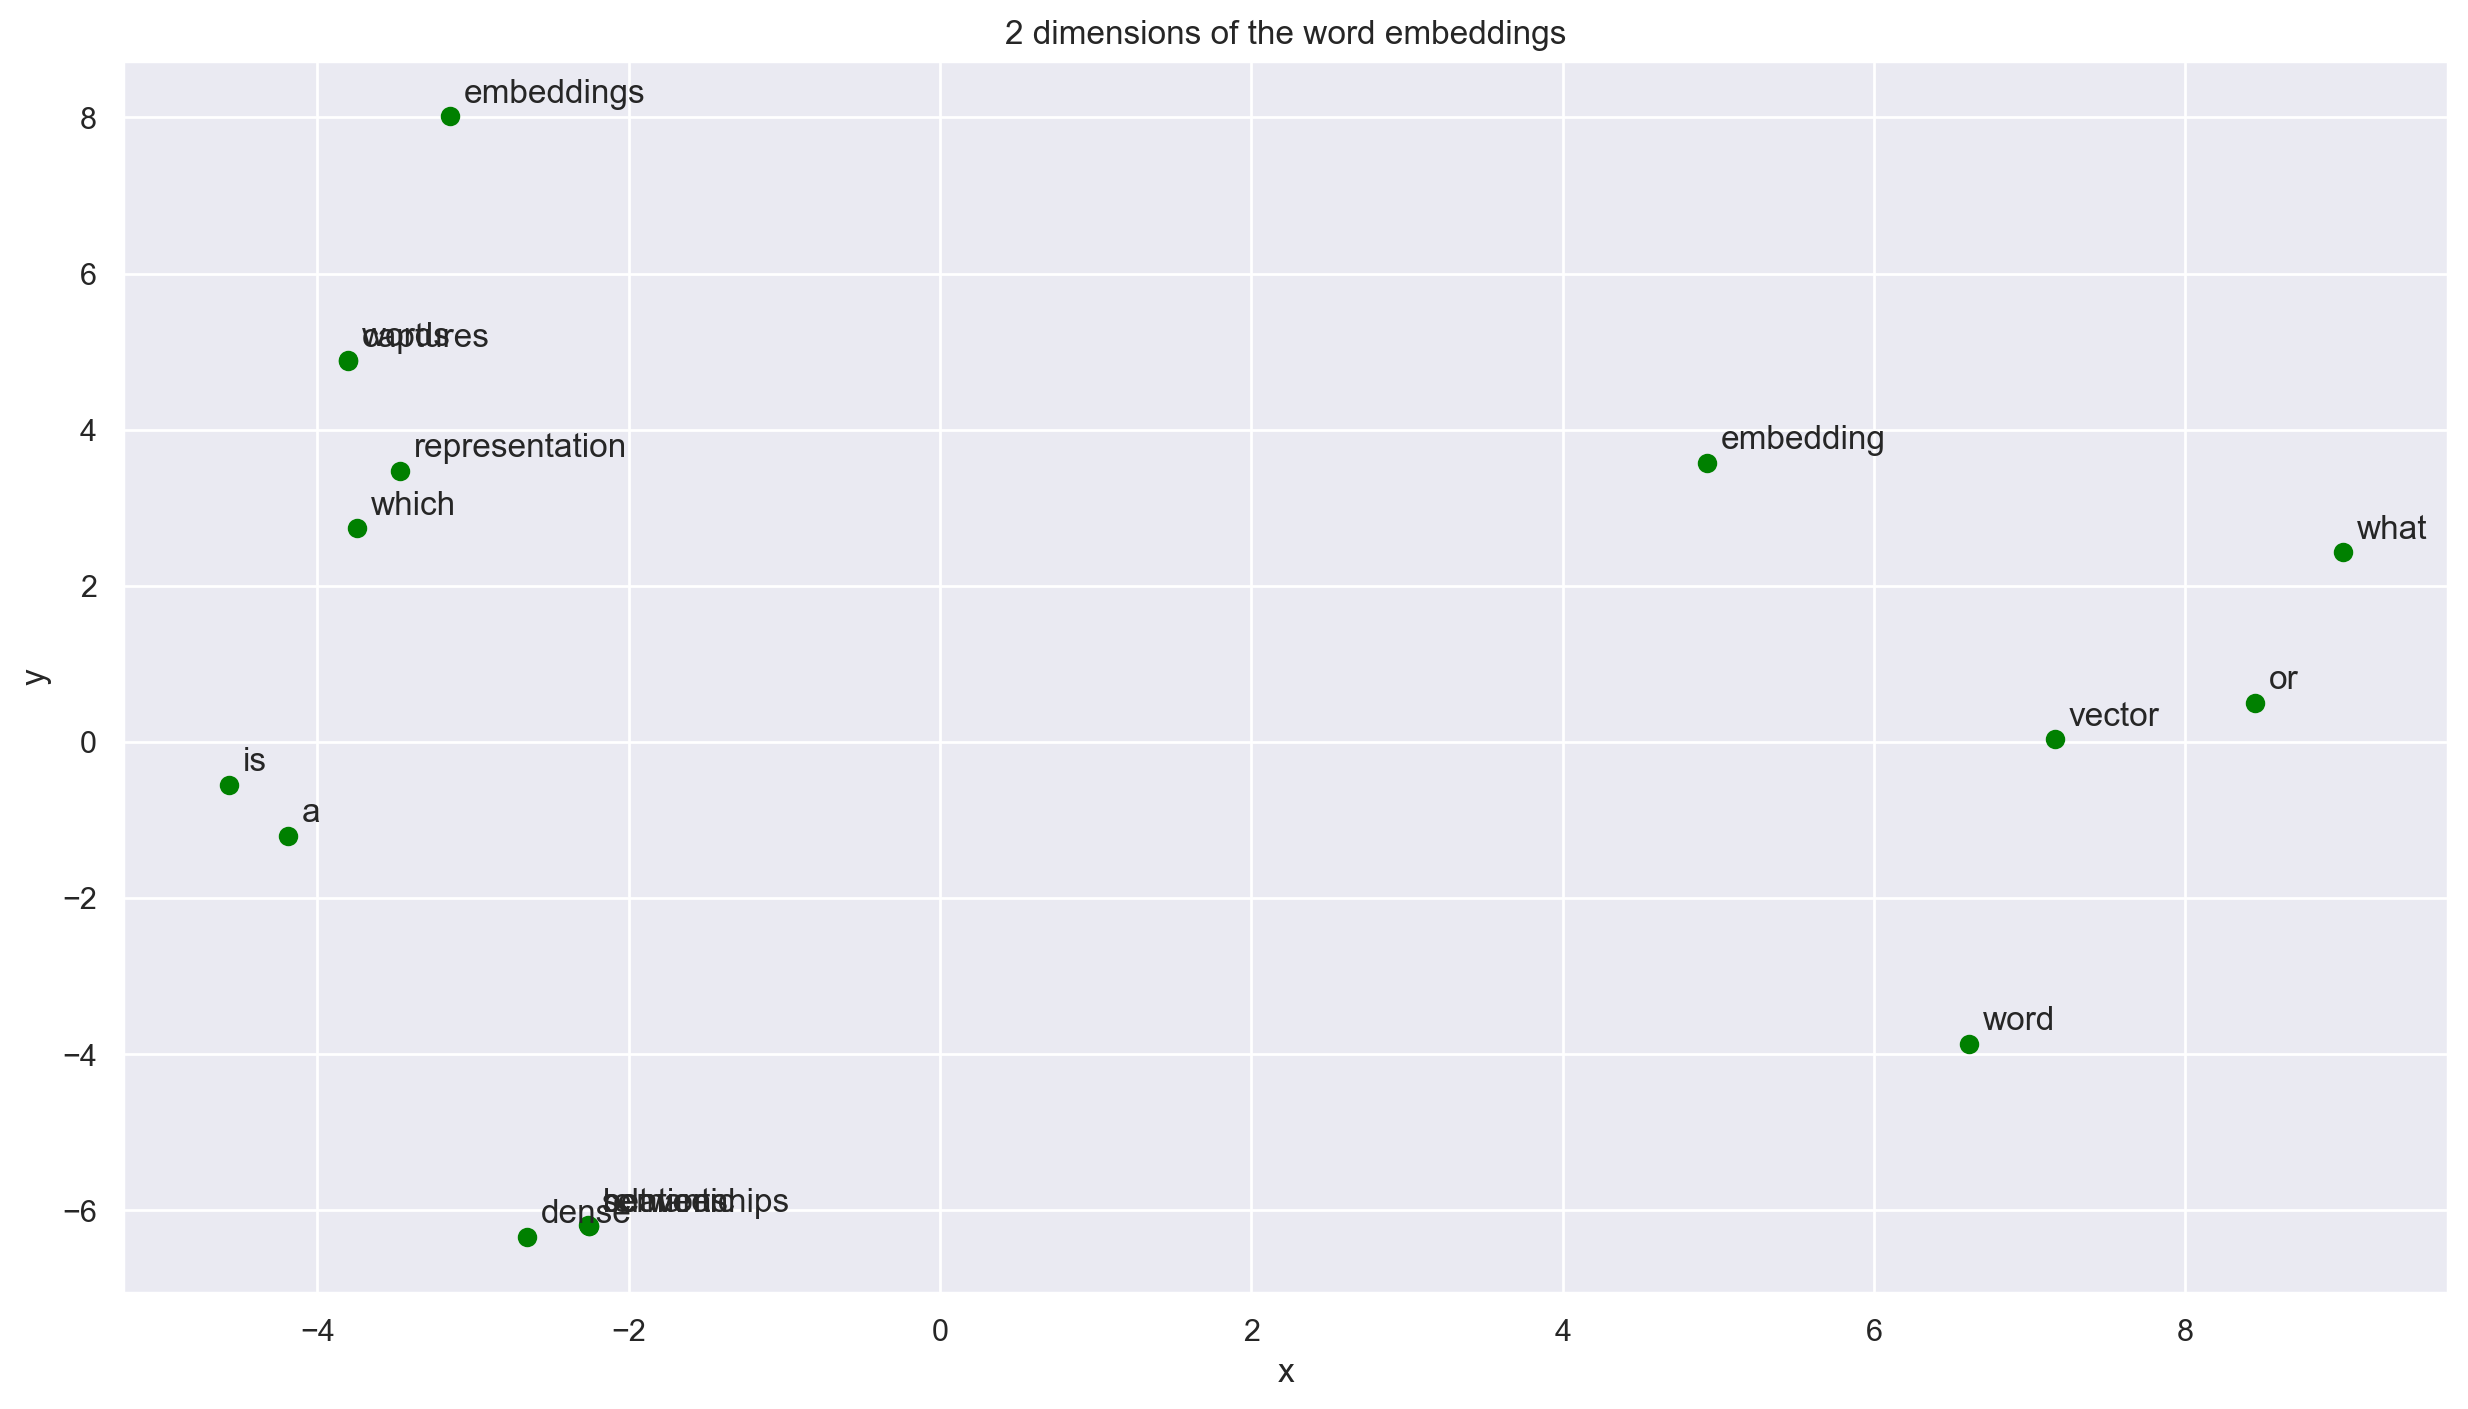

In [43]:
# Visualize the best embeddings
plot_embedding(parameters[best_model_batch_size]["best_embeddings"], voc2idx.values(), vocab)

In [44]:
parameters = parameters[best_model_batch_size]

In [45]:
voc2idx

{'a': 0,
 'is': 1,
 'word': 2,
 'what': 3,
 'embedding': 4,
 'vector': 5,
 'or': 6,
 'embeddings': 7,
 'dense': 8,
 'representation': 9,
 'which': 10,
 'captures': 11,
 'semantic': 12,
 'relationships': 13,
 'between': 14,
 'words': 15}

### First intrinsic evaluation

- Let's take the indices of all the words

- Send them into the grinder

- See if the system can predict the words that were close as the most probable

In [46]:
test_xs = np.arange(vocab_size)
print(test_xs, test_xs.shape)
test_xs = np.expand_dims(test_xs, axis=0)
print(test_xs, test_xs.shape)

softmax_test, _ = forward_propagation(test_xs, parameters)

top_sorted_inds = np.argsort(softmax_test, axis=0)[-5:][::-1]

top_sorted_inds

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] (16,)
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]] (1, 16)


array([[10,  9,  7,  2,  2,  1,  0,  8, 11, 12, 12, 14, 15, 15, 15, 14],
       [ 9,  0,  4,  1,  5,  7,  2,  5, 10,  8, 13, 12, 11, 11, 11, 12],
       [ 1,  8,  0,  0,  0,  0,  1,  6,  0, 11,  9, 13, 14, 14, 14, 13],
       [ 4,  3,  2,  7,  1,  2,  5,  1,  7, 10, 11,  8, 10, 10, 10,  8],
       [ 2,  7,  5,  5, 14,  4,  7,  0,  9,  1,  8, 10, 13, 13, 13, 10]],
      dtype=int64)

In [47]:
for input_ind in range(vocab_size):
    input_word = vocab[input_ind]
    output_words = [
        vocab[output_ind] for output_ind in top_sorted_inds[:,input_ind]
    ]  
    # top 5 words for each word
    print(f"{input_word}'s neighbor words: {output_words}")

a's neighbor words: ['which', 'representation', 'is', 'embedding', 'word']
is's neighbor words: ['representation', 'a', 'dense', 'what', 'embeddings']
word's neighbor words: ['embeddings', 'embedding', 'a', 'word', 'vector']
what's neighbor words: ['word', 'is', 'a', 'embeddings', 'vector']
embedding's neighbor words: ['word', 'vector', 'a', 'is', 'between']
vector's neighbor words: ['is', 'embeddings', 'a', 'word', 'embedding']
or's neighbor words: ['a', 'word', 'is', 'vector', 'embeddings']
embeddings's neighbor words: ['dense', 'vector', 'or', 'is', 'a']
dense's neighbor words: ['captures', 'which', 'a', 'embeddings', 'representation']
representation's neighbor words: ['semantic', 'dense', 'captures', 'which', 'is']
which's neighbor words: ['semantic', 'relationships', 'representation', 'captures', 'dense']
captures's neighbor words: ['between', 'semantic', 'relationships', 'dense', 'which']
semantic's neighbor words: ['words', 'captures', 'between', 'which', 'relationships']
relati

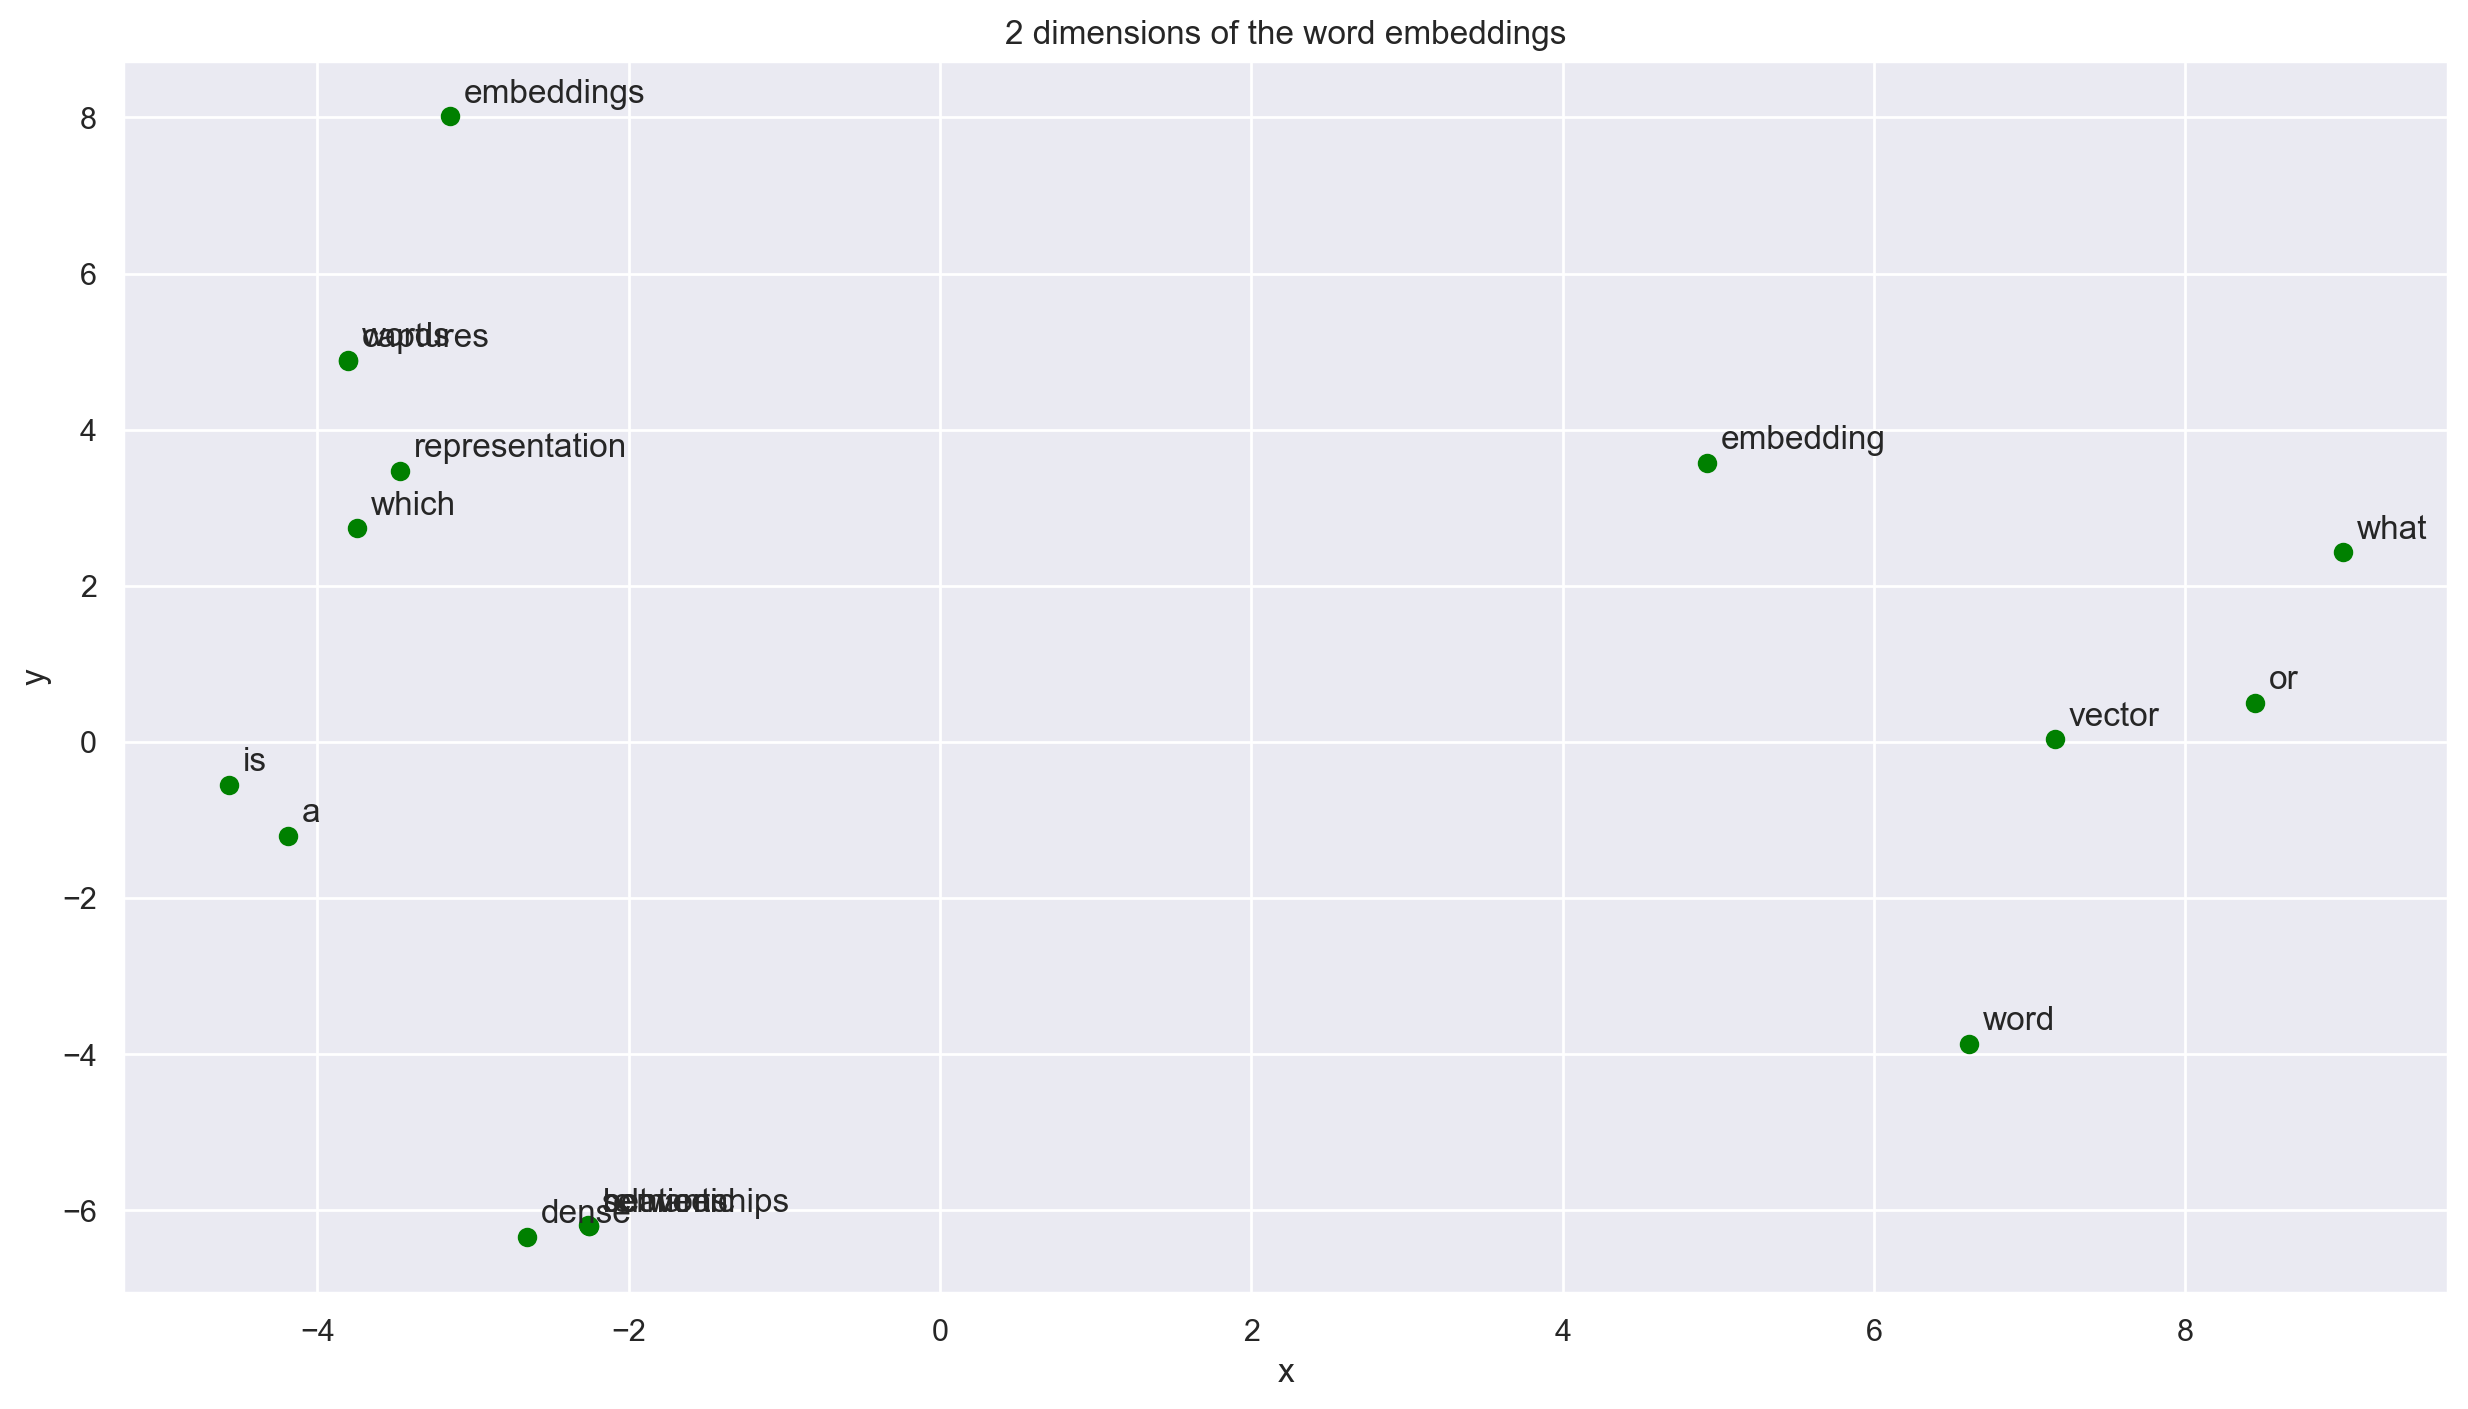

In [48]:
plot_embedding(parameters["best_embeddings"], test_xs[0], vocab)

In [49]:
parameters["best_embeddings"].shape

(16, 50)

In [50]:
# Let's calculate the cosine distance between all words

cos_dists = scipy.spatial.distance.cdist(
    parameters["best_embeddings"], parameters["best_embeddings"], "cosine"
)
print(cos_dists.shape)
vocab

(16, 16)


['a',
 'is',
 'word',
 'what',
 'embedding',
 'vector',
 'or',
 'embeddings',
 'dense',
 'representation',
 'which',
 'captures',
 'semantic',
 'relationships',
 'between',
 'words']

In [51]:
def costs_heatmap(costs, vocab):
    plt.figure(figsize=(9, 8))
    sns.heatmap(
        costs,
        annot=costs.round(1),
        xticklabels=vocab,
        yticklabels=vocab,
        cmap="RdPu",
    )

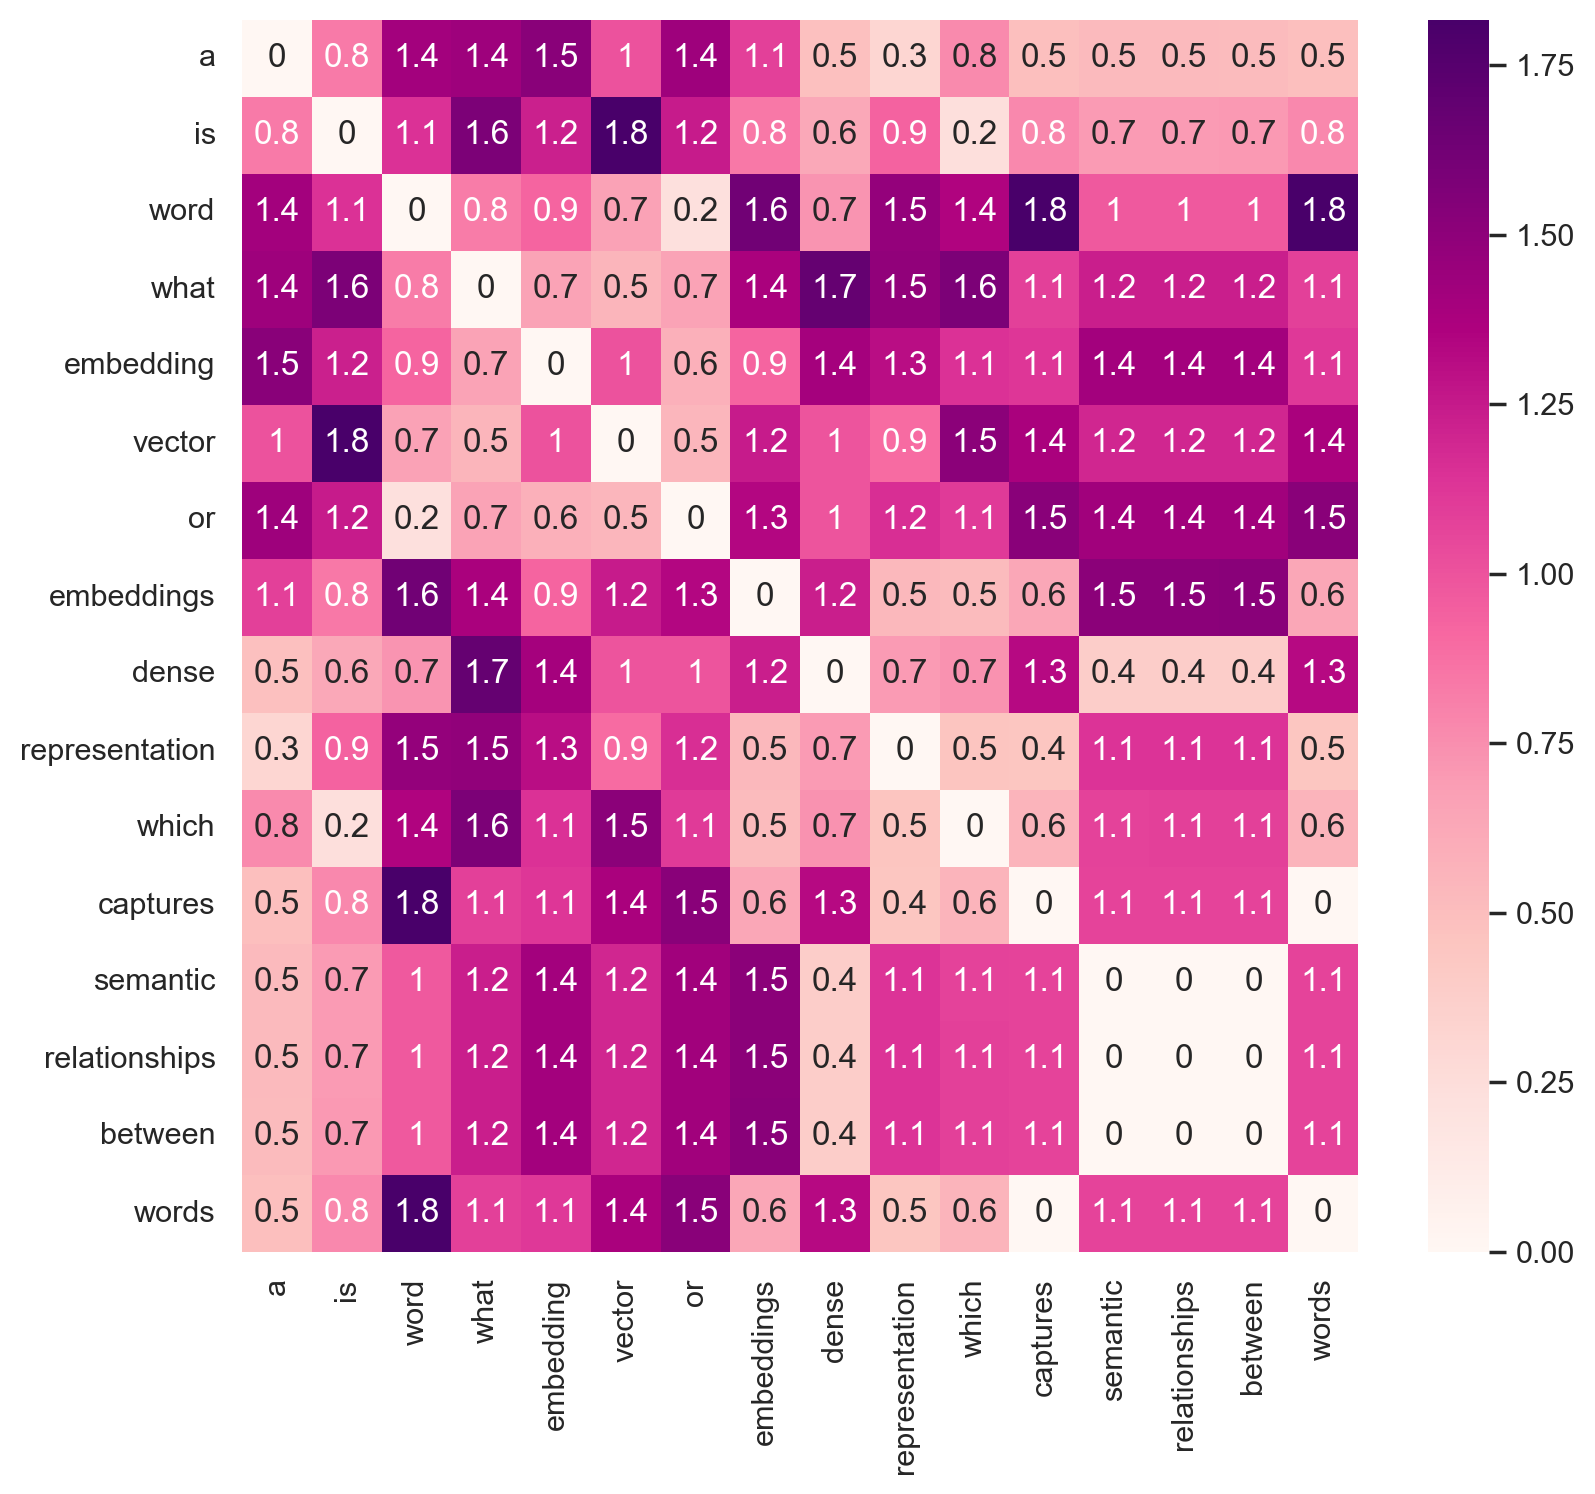

In [52]:
costs_heatmap(cos_dists, vocab)

The heatmap show how similar words are to each other based on their cosine distance in the embedding space. If the cosine distance is near 0, it means the word's embeddings are close one each other in the vector space. If it's close to 1, the words are different. According to the heatmap.

The heatmap shows that the words "semantic," "relationships," and "between" look similar because of the small amount of text used to teach the model. Normally we need a lot of text to show how words are related. If not enough text is used, words that are actually different may seem more similar than they really are.

## A longer text

In [53]:
text = """The celestial sphere is an imaginary projection of the Sun, Moon,
planets, stars, and all astronomical bodies upon an imaginary sphere surrounding
Earth. Although originally developed as part of the ancient Greek concept of an
Earth-centered (geocentric) universe, the hypothetical celestial sphere gives
astronomers an important tool for fixing the location and plotting movements of
celestial objects. Ancient Greek astronomers envisioned concentric crystalline
spheres centered around Earth, upon which the Sun, Moon, planets, and stars
moved. Although heliocentric (Sun-centered) models of the universe were also
proposed by the Greeks, they were disregarded as counterintuitive to the
apparent motions of celestial bodies across the sky. Corresponding to Earth’s
rotation, the celestial sphere rotates through 1° in about four minutes. Because
of this, sunrise, sunset, moonrise, and moon-set, all take approximately two
minutes because both the Sun and Moon have the same apparent size on the
celestial sphere (about 0.5°). The Sun is, of course, much larger, but the Moon
is much closer. """

### Do the same thing again

for this larger text

In [54]:
tokens = tokenize(text)
print(Counter(tokens))

vocab, voc2idx = build_vocab(tokens, show_df=True)
xs, ys = generate_skip_data(tokens, 3)

xs, ys = np.array(xs), np.array(ys)
vocab_size = len(vocab)

m = ys.shape[1]
print("m:", m)

Counter({'the': 16, 'of': 8, 'celestial': 6, 'sphere': 5, 'sun': 5, 'moon': 5, 'and': 5, 'an': 4, 'earth': 4, 'is': 3, 'centered': 3, 'imaginary': 2, 'planets': 2, 'stars': 2, 'all': 2, 'bodies': 2, 'upon': 2, 'although': 2, 'as': 2, 'ancient': 2, 'greek': 2, 'universe': 2, 'astronomers': 2, 'were': 2, 'to': 2, 'apparent': 2, 'about': 2, 'minutes': 2, 'because': 2, 'much': 2, 'projection': 1, 'astronomical': 1, 'surrounding': 1, 'originally': 1, 'developed': 1, 'part': 1, 'concept': 1, 'geocentric': 1, 'hypothetical': 1, 'gives': 1, 'important': 1, 'tool': 1, 'for': 1, 'fixing': 1, 'location': 1, 'plotting': 1, 'movements': 1, 'objects': 1, 'envisioned': 1, 'concentric': 1, 'crystalline': 1, 'spheres': 1, 'around': 1, 'which': 1, 'moved': 1, 'heliocentric': 1, 'models': 1, 'also': 1, 'proposed': 1, 'by': 1, 'greeks': 1, 'they': 1, 'disregarded': 1, 'counterintuitive': 1, 'motions': 1, 'across': 1, 'sky': 1, 'corresponding': 1, 's': 1, 'rotation': 1, 'rotates': 1, 'through': 1, '1': 1, 

,token,count
0,the,16
1,of,8
2,celestial,6
3,sphere,5
4,sun,5
...,...,...
89,5,1
90,course,1
91,larger,1
92,but,1


m: 984


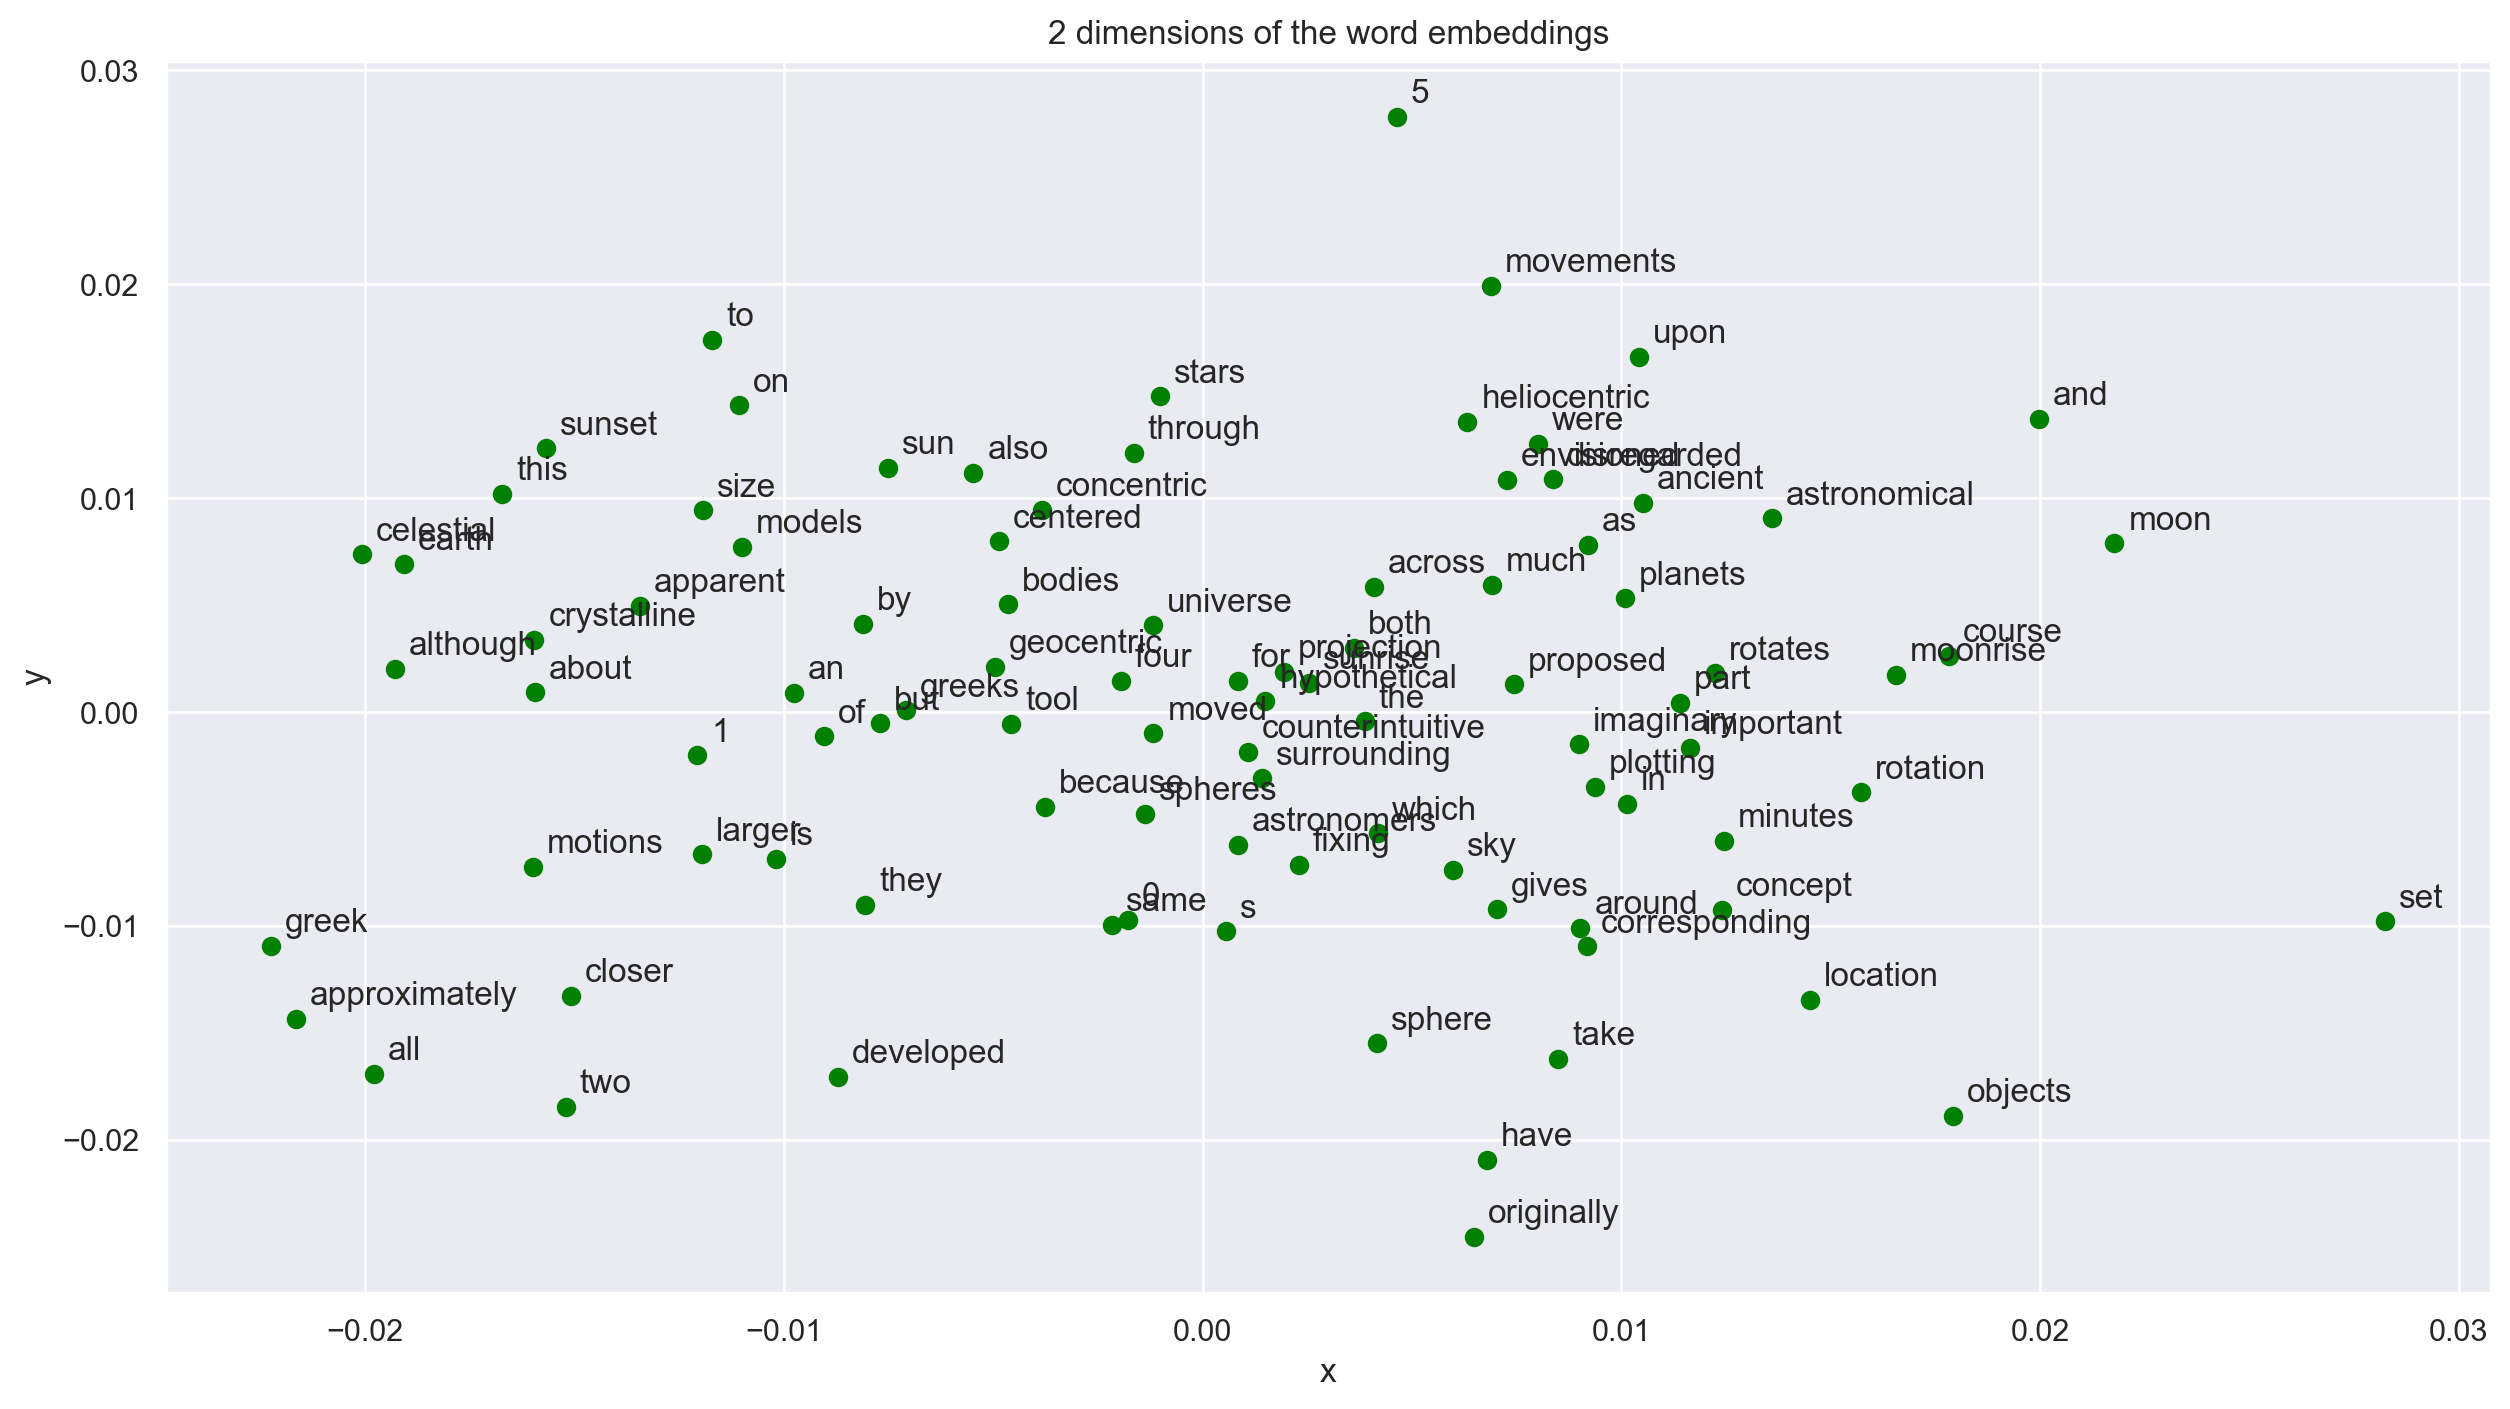

In [55]:
# Initialize the parameters and visualize the distribution (normal, random)
parameters = initialize_parameters(len(vocab), 5)
plot_embedding(parameters["EMBS"], voc2idx.values(), vocab)

Cost after epoch    0: 36.3466
Cost after epoch  200: 34.2873
Cost after epoch  400: 29.9678
Cost after epoch  600: 27.6425
Cost after epoch  800: 27.0506
Cost after epoch 1000: 26.7591
Cost after epoch 1200: 26.9415
Cost after epoch 1400: 26.9114
Cost after epoch 1600: 26.7347
Cost after epoch 1800: 26.7117
Cost after epoch 2000: 26.8522
Cost after epoch 2200: 26.9130
Cost after epoch 2400: 26.8550
Cost after epoch 2600: 26.7664
Cost after epoch 2800: 26.6807
Cost after epoch 3000: 26.6974
Cost after epoch 3200: 26.7700
Cost after epoch 3400: 26.8208
Cost after epoch 3600: 26.7963
Cost after epoch 3800: 26.7464
Cost after epoch 4000: 26.6908
Cost after epoch 4200: 26.6535
Cost after epoch 4400: 26.6362
Cost after epoch 4600: 26.6375
Cost after epoch 4800: 26.6413
training time: 0:00:39.102586
🚧 TODO I've kept the embedding of epoch 4461 with cost 26.6310.


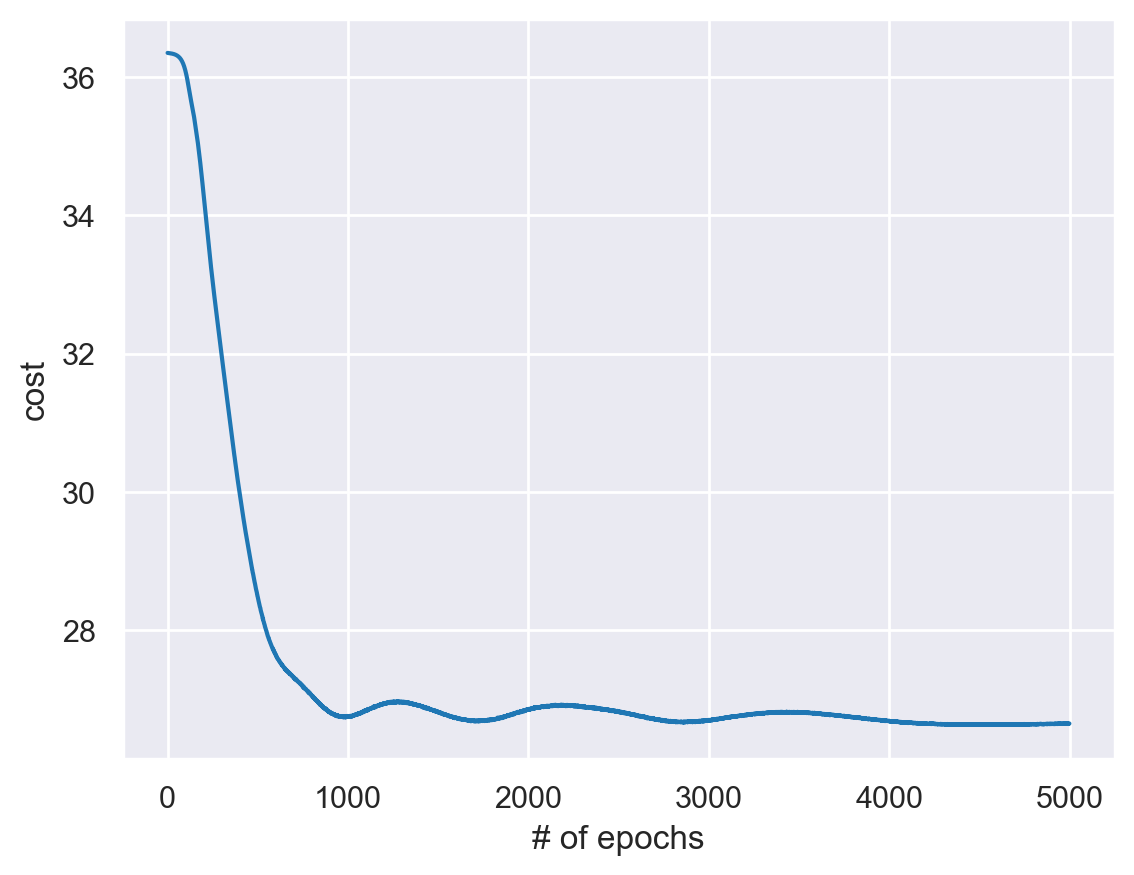

In [56]:
# Be patient:
parameters, _ = skipgram_model_training(
    xs,
    ys,
    vocab_size,
    emb_size=50,
    learning_rate=0.05,
    epochs=5000,
    batch_size=128,
    parameters=None,
    print_cost=True,
)

In [57]:
test_xs = np.arange(vocab_size)
test_xs = np.expand_dims(test_xs, axis=0)
softmax_test, _ = forward_propagation(test_xs, parameters)
top_sorted_inds = np.argsort(softmax_test, axis=0)[-5:][::-1]
for input_ind in range(10):
    input_word = vocab[input_ind]
    output_words = [
        vocab[output_ind] for output_ind in top_sorted_inds[:, input_ind]
    ]  

    print(f"{input_word}'s neighbor words: {output_words}")

the's neighbor words: ['moon', 'celestial', 'sphere', 'of', 'is']
of's neighbor words: ['sun', 'ancient', 'centered', 'were', 'larger']
celestial's neighbor words: ['sphere', 'an', 'astronomers', 'the', 'greek']
sphere's neighbor words: ['an', 'celestial', 'although', '5', 'imaginary']
sun's neighbor words: ['of', 'planets', 'moon', 'course', '0']
moon's neighbor words: ['and', 'stars', 'sun', 'take', 'planets']
and's neighbor words: ['the', 'moon', 'of', 'all', 'although']
an's neighbor words: ['imaginary', 'sphere', 'geocentric', 'surrounding', 'for']
earth's neighbor words: ['the', 'of', 'sphere', 'centered', 'universe']
is's neighbor words: ['much', 'moon', 'closer', 'but', 'course']


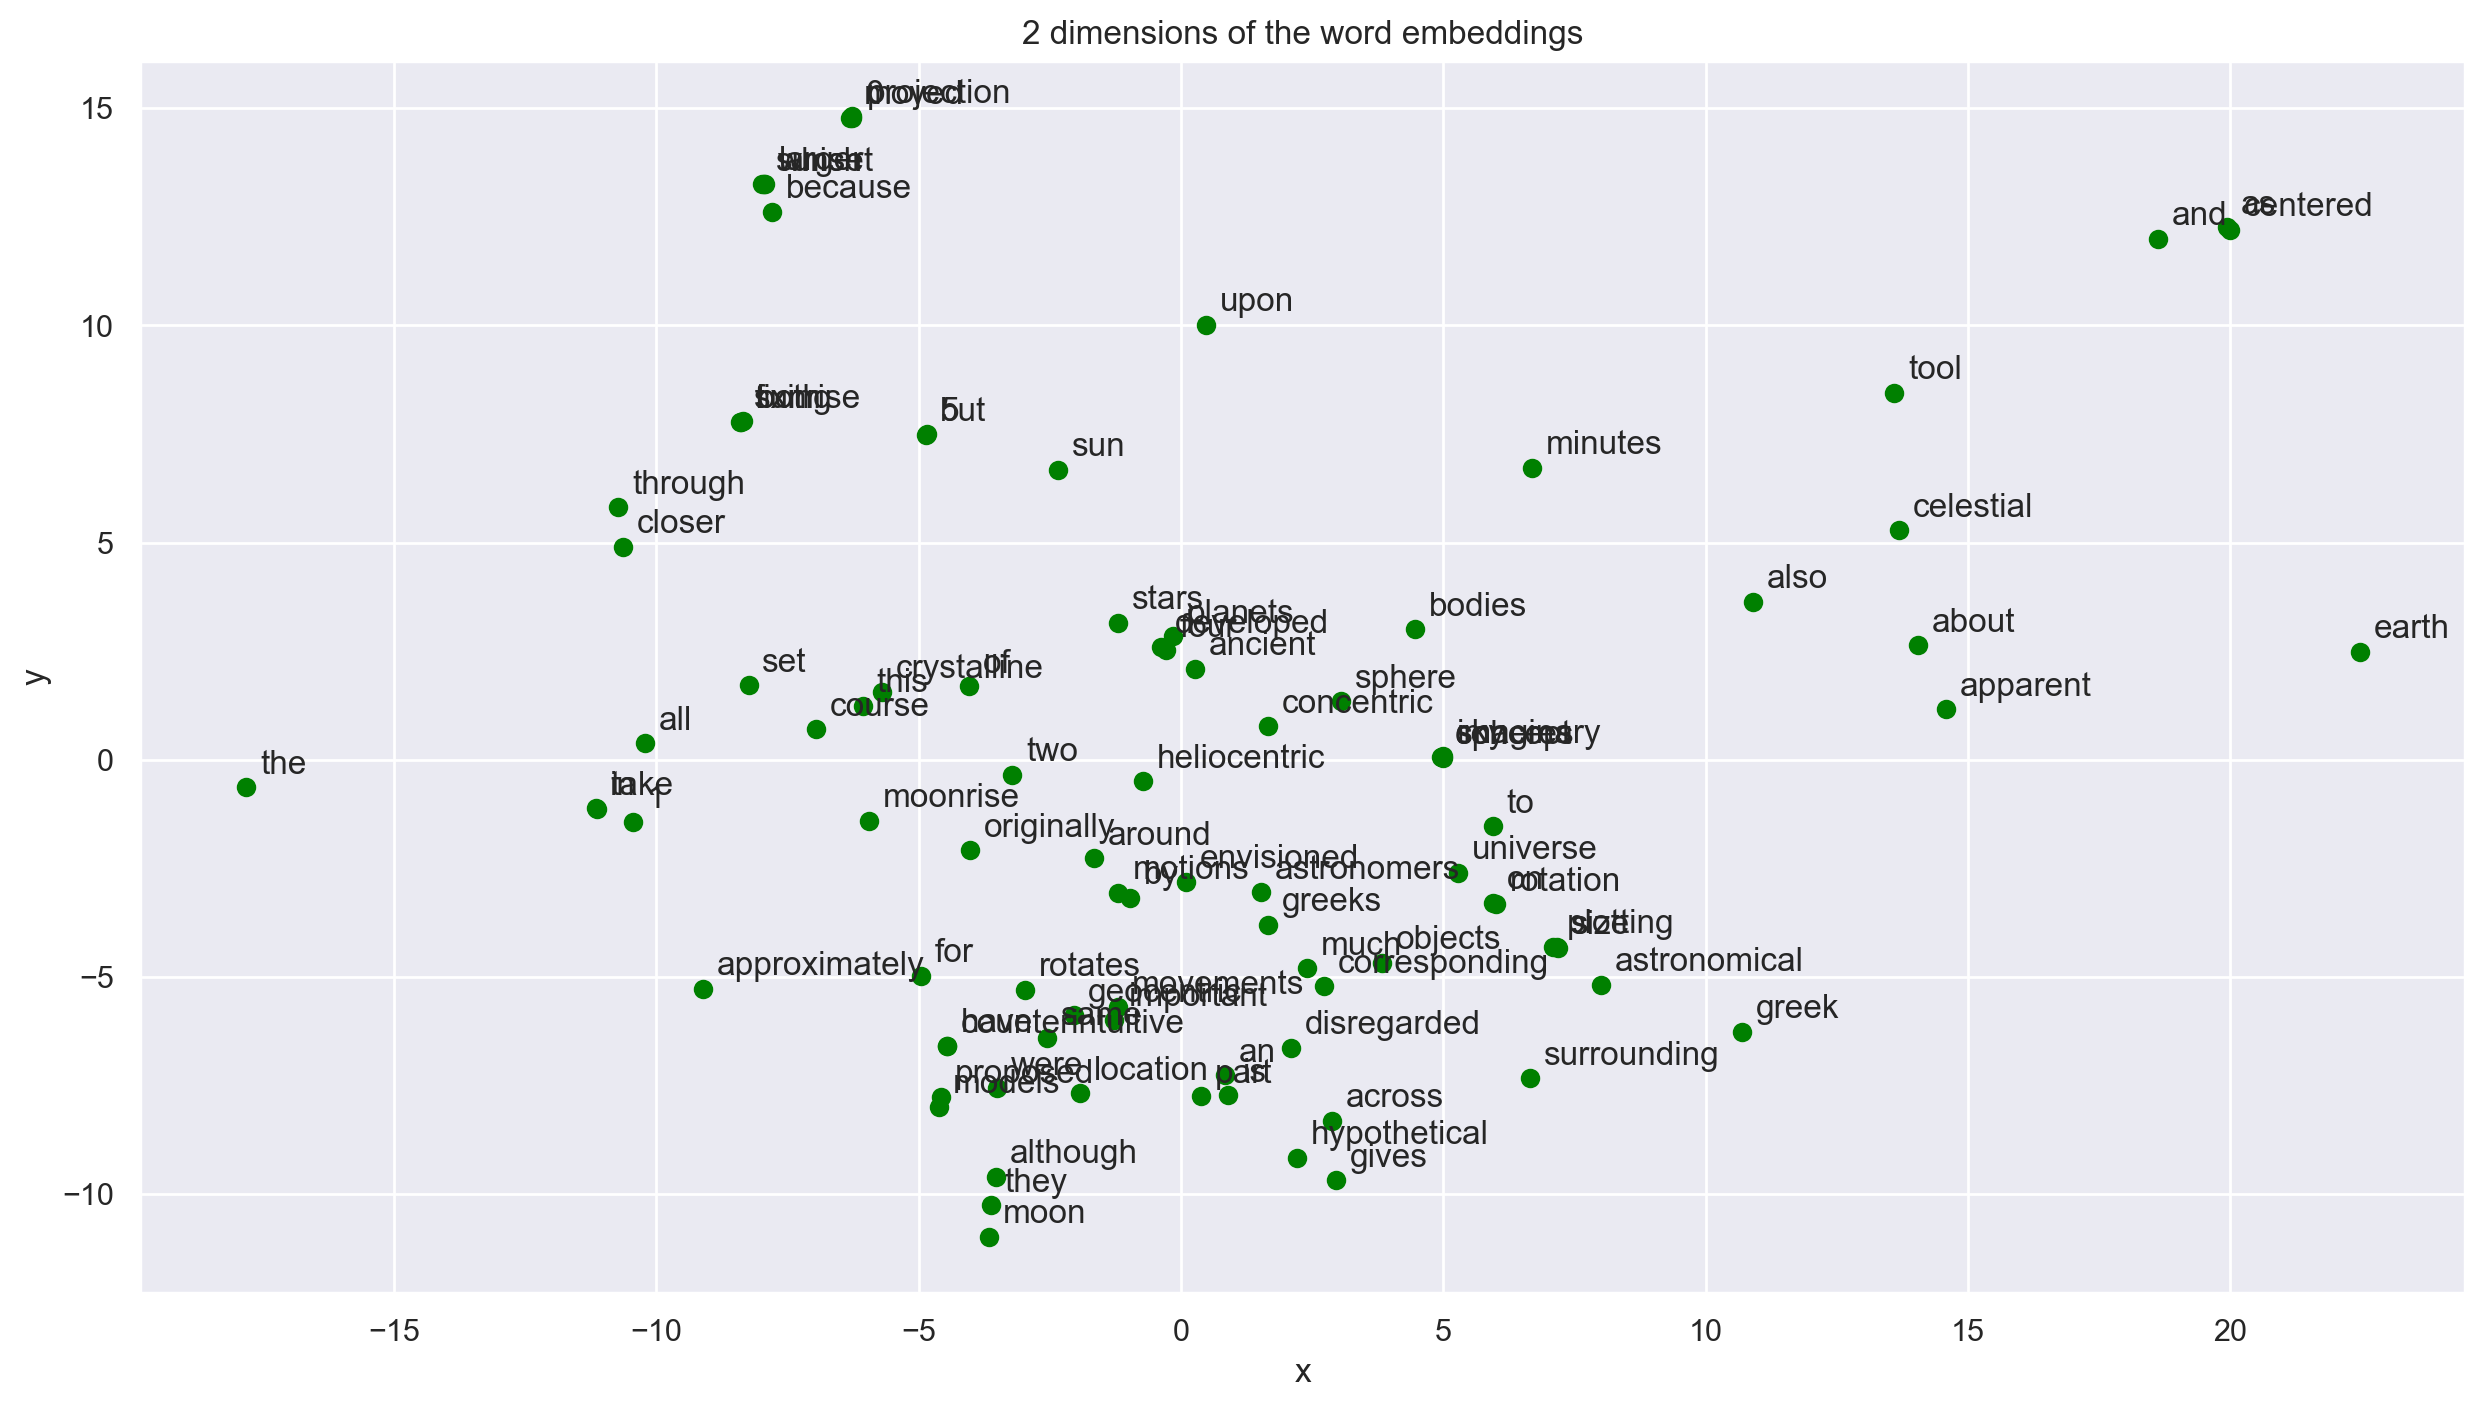

In [58]:
plot_embedding(parameters["EMBS"], voc2idx.values(), vocab)

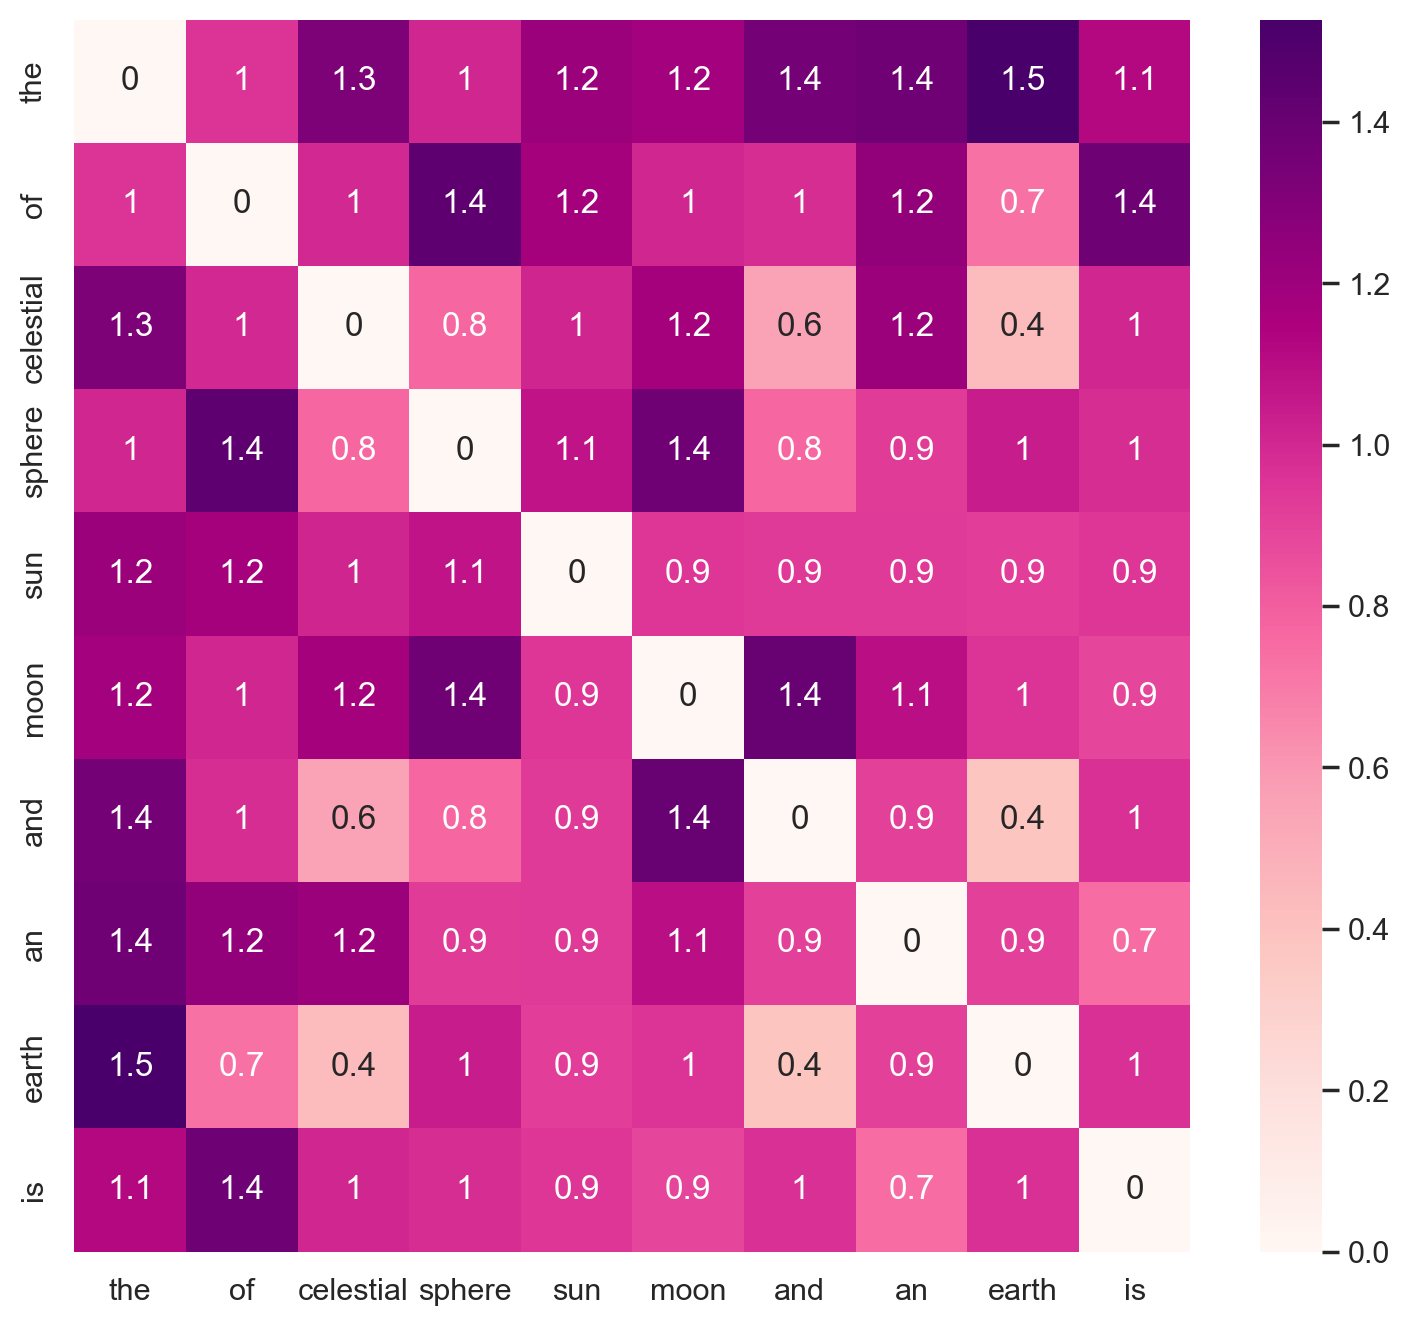

In [59]:
# very (!) slow and not very telling as it is.

word_freq = Counter(tokens)
most_freq_words = [word for word, freq in word_freq.most_common(10)]  
most_freq_inds = [voc2idx[word] for word in most_freq_words]

cos_dists = scipy.spatial.distance.cdist(
    parameters["EMBS"][most_freq_inds], parameters["EMBS"][most_freq_inds], "cosine"
)
costs_heatmap(cos_dists, most_freq_words)

### Conclusions:

- It works, but we would like to train on a much larger corpus

  - For that, we should:
  
    - Not exceed the lines when computing the neighborhood
  
    - Use negative sampling
  
    - Maybe implement a part in C and optimized for graphic card -- 
      or use a deep learning module (PyTorch, TensorFlow...)

- We will rely on an already implemented module: **Gensim**

→ Next section

____________

### 🌸 Gensim Word Embedding

- Word embedding
 
  - 🚧 TODO: complete a function to read a pre-computed embedding
 
  - 🚧 TODO: normalize vectors
 
  - 🚧 TODO: complete the function that finds the closest words by cosine distance
 
  - 🚧 TODO: test the nearest words
 
  - 🚧 mini-TODO: complete and test the function that computes analogies to see if our plotting is biased

- Later: text classification

  - 🚧 TODO: find and remove an outlier in our texts (to understand that the method works very well if the texts are very different)

  - Optional TODO: other methods than k-nearest neighbors

  - Optional TODO: redo based on keywords only

All TODOs are marked with the symbol 🚧 

#### Load the pre-calculated word2vec 
  
  - Get `enwiki-50k_100d-clean.txt` here and put it next to your notebook 
    (recommended: `../data/enwiki/`)
  
  - It consists in a reduction to the 50k most frequent types of the full word2vec [pretrainded](https://wikipedia2vec.github.io/wikipedia2vec/pretrained/) on the complete English Wikipedia.  
  
    In particular this [file](http://wikipedia2vec.s3.amazonaws.com/models/en/2018-04-20/enwiki_20180420_100d.txt.bz2)
  
  - Open the file and explore the format
  
  - 🚧 Write a `read_vectors` function that gives a numpy matrix `embeddings` with one row per type (~ one word), each row represents the word. `embeddings[i, :]` corresponds to one type.

In [60]:
# # comment out once the file is downloaded or taken manually
# !wget --no-check-certificate https://gerdes.fr/saclay/enwiki-50k_100d.zip
# !unzip enwiki-50k_100d.zip

In [61]:
# # extraction from big embedding
# c = 0
# with (
#     open("enwiki-50k_100d.txt") as in_f,
#     open("enwiki-50k_100d-clean.txt", "W") as out_f,
# ):
#     for row in in_f:
#         if c == 0:
#             c += 1
#             # continue
#         if not row.strip().startswith("ENTITY/"):
#             out_f.write(row)
#             c += 1
#         if c > 50000:
#             break

In [62]:
def read_vectors(infile, vocab_size=50000, dimension=100):
    """
    function that reads a backup of an embedding
    returns
    - a word dictionary type -> index
    - the inverse dictionary
    - a matrix containing a vector of words per word type
    check the file to understand the format
    """
    embeddings = np.zeros((vocab_size, dimension))
    w2i, i2w = {}, {}  # as before
    i = 0
    for line in open(infile):
        
        splitted = line.strip().split()
        w2i[splitted[0]] = i
        i2w[i] = splitted[0]
        embeddings[i] = np.array(splitted[1:], dtype=float)
        i += 1
        
    assert len(w2i) == len(i2w) == len(embeddings)
    return w2i, i2w, embeddings

In [63]:
w2i, i2w, embeddings = read_vectors(ENWIKI_FP)

print(len(w2i), len(i2w), embeddings.shape)

50000 50000 (50000, 100)


### Objectives

We want to make a python function that for a given word returns the K nearest (semantic) neighbors

To do this, we need to 

1. calculate the cosine distance between them

2. order the distances by decreasing orders


#### 1. Calculating the cosine distance
**Hint**, we can do this in two substeps: 
- 🚧 normalize the embeddings (with respect to the rows, i.e., each word vector to a unit norm)
- 🚧 calculate scalar product between the source word embedding with the whole embedding space

In [64]:
normed_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

**⚠ Achtung!!!**:

- To simplify the calculations later, we will base our calculations on the `normed_embeddings` matrix. Thus, we won't need to divide the dot product of the two vectors by their norms (the cosine similarity of two unit vectors is just the dot product of the vectors).

- If you want to perform a similarity calculation based on another measure (Euclidean distance?), then you will have to base your calculations on the raw `embeddings` matrix (which is not normalized!)

In [65]:
def find_closest_words_from_vector(vector, k_max=10):
    """For a given vector, find the K nearest semantic neighbors"""
    closest_words = []

    cosine_similarities = np.dot(normed_embeddings, vector)
    
    # matrix sorted from smallest to largest
    sorted_indexes = np.argsort(cosine_similarities)
    # Only K largest is of interest to us
    for k in range(1, k_max + 1):  # to take the last elements, we start with -1
    
        neighboor_index = sorted_indexes[-k]
        closest_words.append(i2w[neighboor_index])
        
    return closest_words

In [66]:
def find_closest_words_from_word(word, k_max=10):
    """For a given word 'word', find the K nearest semantic neighbors"""
    word_index = w2i[word]
    word_vector = normed_embeddings[word_index]
    closest_words = find_closest_words_from_vector(word_vector, k_max)
    return closest_words

In [67]:
def pretty_show(closest_words):
    """prettify the print for the closest words"""
    for word in closest_words:
        print(word.ljust(15, " "))
    print("___\n")

In [68]:
# Creative time! Let's test our function on some terms
pretty_show(find_closest_words_from_word("french"))
pretty_show(find_closest_words_from_word("what"))
# trained on Wikipédia. --> few swear words... (e.g., holy ...)
pretty_show(find_closest_words_from_word("holy"))
pretty_show(find_closest_words_from_word("cool"))

french         
françois       
belgian        
haitian        
leclerc        
spanish        
étienne        
algerian       
france         
pierre         
___

what           
why            
really         
whatever       
something      
everything     
nothing        
definitely     
how            
actually       
___

holy           
blessed        
redeemer       
sacrament      
sacred         
rosary         
sepulchre      
baptism        
saviour        
eucharist      
___

cool           
warm           
chilly         
hot            
sunny          
cooler         
cold           
winters        
wet            
summers        
___



### Analogies

Finally the pretty analogies in the embeddings!

In [69]:
def find_analogies(wpos1, wpos2, wneg):
    """
    wpos1: the first positive word
    wpos2: the 2nd positive word
    wneg: the negative word
    Find the analog "analog" such that
        <"analog" is to "wpos2" what "wneg" is to "wpos1">
    For example: <"queen" is to "woman" what "king" is to "man">
    """
    # add the positive vectors, substract the negative vector:
    vector_analog  = normed_embeddings[w2i[wpos2]] + normed_embeddings[w2i[wpos1]] - normed_embeddings[w2i[wneg]]
    
    return find_closest_words_from_vector(vector_analog)

In [70]:
pretty_show(find_analogies("king", "woman", "man"))
pretty_show(find_analogies("nurse", "man", "woman"))  # Watch out for bias!: fireman, firefighter
# 🚧 TODO: Find other "questionable" example
pretty_show(find_analogies("engineer", "woman", "man"))
pretty_show(find_analogies("doctor", "woman", "man")) # look at the second analogy: midwife
pretty_show(find_analogies("policeman", "black", "white")) # Interesting!
pretty_show(find_analogies("policeman", "white", "black")) # Interesting!


queen          
king           
monarch        
consort        
regent         
princess       
throne         
princesses     
mistress       
dowager        
___

nurse          
medic          
sgt            
fireman        
vet            
firefighter    
medics         
janitor        
technician     
paramedic      
___

engineer       
technologist   
educator       
technician     
engineers      
electrician    
agronomist     
draftsman      
designer       
physician      
___

doctor         
midwife        
obstetrician   
nurse          
dentist        
physician      
pediatrician   
gynecologist   
dermatologist  
woman          
___

policeman      
gunman         
kidnapper      
thief          
smuggler       
henchman       
gangster       
accomplice     
hitman         
assassin       
___

policeman      
waiter         
chauffeur      
policemen      
gunman         
shopkeeper     
police         
bartender      
landlady       
kidnapper      
___



# 💥 Text classification by embeddings

In [71]:
def doc2vec(text):
    """
    The function takes a text, cuts it into tokens
    For each token, if the token is in w2i, we take its vector
    We add the vectors and renormalize
    Returns: vector of the same format as the ones we have for each word
    """
    tokens = re.findall(r"\w+", text)
    vectors = [normed_embeddings[w2i[t]] for t in tokens if t in w2i]
    somme = sum(vectors)
    normalised = somme / np.sqrt(np.sum(somme ** 2))
    return normalised

In [72]:
vex = doc2vec("let's see how this works, this word2vec thing!")
vex

array([ 0.07387233,  0.12554409, -0.03471597,  0.12111489, -0.05750589,
       -0.06976969,  0.11069114, -0.00413172, -0.03993599, -0.11440254,
       -0.02002395, -0.06674013,  0.05186859,  0.02370464,  0.14302237,
       -0.17568769, -0.08483407, -0.11740287,  0.02232566,  0.0244962 ,
       -0.02370285, -0.04889281, -0.09490498,  0.1441267 , -0.14840299,
       -0.06995096,  0.01508538, -0.13237274,  0.08919033,  0.23805662,
        0.15732137,  0.04487463,  0.06990924,  0.10595372, -0.04686351,
        0.04037394,  0.01301547,  0.00769076,  0.03119487, -0.04906946,
       -0.01264446,  0.11649464, -0.08002043,  0.05053645, -0.15290941,
       -0.04462939, -0.09043782,  0.16251262, -0.16145541,  0.11196586,
       -0.07868526,  0.11920033, -0.05469899,  0.03121956,  0.04826111,
       -0.0215742 , -0.08538961,  0.00766825, -0.0369743 ,  0.070069  ,
       -0.14247876, -0.10275707, -0.06764206,  0.13842822,  0.22479674,
       -0.1171155 , -0.15569672, -0.01623687, -0.02873219, -0.18

---